In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
gc.enable()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.io as pio




from sklearn.metrics import roc_auc_score
import lightgbm as lgb

%matplotlib inline
warnings.filterwarnings("ignore")

gc.enable()

## Data

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target `isFraud`.

The data is broken into two files `identity` and `transaction`, which are joined by TransactionID. Not all transactions have corresponding identity information.


### Categorical Features - Transaction
* `ProductCD`
* `card1 - card6`
* `addr1, addr2`
* `P_emaildomain`
* `R_emaildomain`
* `M1 - M9`

### Categorical Features - Identity

* `DeviceType`
* `DeviceInfo`
* `id_12 - id_38`

The `TransactionDT` feature is a timedelta from a given reference datetime (not an actual timestamp).




### Files
* train_{transaction, identity}.csv - the training set
* test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
* sample_submission.csv - a sample submission file in the correct format


### Questions
I will start exploring based on Categorical Features and Transaction Amounts. The aim is answer some questions like:

What type of data we have on our data?
How many cols, rows, missing values we have?
Whats the target distribution?
What's the Transactions values distribution of fraud and no fraud transactions?
We have predominant fraudulent products?
What features or target shows some interesting patterns?
And a lot of more questions that will raise trought the exploration.

In [2]:
print(os.listdir("data/"))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    return summary

In [274]:
%%time
train_identity = pd.read_csv("data/train_identity.csv", )
train_transaction = pd.read_csv("data/train_transaction.csv", )
test_identity = pd.read_csv("data/test_identity.csv", )
test_transaction = pd.read_csv("data/test_transaction.csv",)


Wall time: 33.8 s


In [5]:
print("Shape of Data:")
print("train identity shape", train_identity.shape)
print("train transaction shape", train_transaction.shape)
print("test identity shape", test_identity.shape)
print("test transaction shape", test_transaction.shape)

Shape of Data:
train identity shape (144233, 41)
train transaction shape (590540, 394)
test identity shape (141907, 41)
test transaction shape (506691, 393)


In [6]:
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [7]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

In [8]:
train_transaction_id_ratio = round(np.sum(train_transaction['TransactionID'].
                                          isin(train_identity['TransactionID'])) / test_transaction.shape[0] * 100, 2)

test_transaction_id_ratio = round(np.sum(test_transaction['TransactionID'].
                                          isin(test_identity['TransactionID'])) / test_transaction.shape[0] * 100, 2)

In [9]:
print(f"{train_transaction_id_ratio} of transactionID in train_transaction is in train_identity dataset")
print(f"{test_transaction_id_ratio} of transactionID in test_transaction is in test_identity dataset")

28.47 of transactionID in train_transaction is in train_identity dataset
28.01 of transactionID in test_transaction is in test_identity dataset


In [10]:
train_transaction.columns[:100]

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
       'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17',
       'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37',
       'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45'],
      dtype='object')

In [11]:
resumetable(train_transaction)[:50]

Dataset Shape: (590540, 394)


Name   dtypes  Missing  Uniques First Value Second Value  \
0    TransactionID    int64        0   590540     2987000      2987001   
1          isFraud    int64        0        2           0            0   
2    TransactionDT    int64        0   573349       86400        86401   
3   TransactionAmt  float64        0    20902        68.5           29   
4        ProductCD   object        0        5           W            W   
5            card1    int64        0    13553       13926         2755   
6            card2  float64     8933      500         NaN          404   
7            card3  float64     1565      114         150          150   
8            card4   object     1577        4    discover   mastercard   
9            card5  float64     4259      119         142          102   
10           card6   object     1571        4      credit       credit   
11           addr1  float64    65706      332         315          325   
12           addr2  float64    65706       74          87           87   
13           dist1  float64   352271     2651          19          NaN   
14           dist2  float64   552913     1751         NaN          NaN   
15   P_emaildomain   object    94456       59         NaN    gmail.com   
16   R_emaildomain   object   453249       60         NaN          NaN   
17              C1  float64        0     1657           1            1   
18              C2  float64        0     1216           1            1   
19              C3  float64        0       27           0            0   
20              C4  float64        0     1260           0            0   
21              C5  float64        0      319           0            0   
22              C6  float64        0     1328           1            1   
23              C7  float64        0     1103           0            0   
24              C8  float64        0     1253           0            0   
25              C9  float64        0      205           1            0   
26             C10  float64        0     1231           0            0   
27             C11  float64        0     1476           2            1   
28             C12  float64        0     1199           0            0   
29             C13  float64        0     1597           1            1   
30             C14  float64        0     1108           1            1   
31              D1  float64     1269      641          14            0   
32              D2  float64   280797      641         NaN          NaN   
33              D3  float64   262878      649          13          NaN   
34              D4  float64   168922      808         NaN            0   
35              D5  float64   309841      688         NaN          NaN   
36              D6  float64   517353      829         NaN          NaN   
37              D7  float64   551623      597         NaN          NaN   
38              D8  float64   515614    12353         NaN          NaN   
39              D9  float64   515614       24         NaN          NaN   
40             D10  float64    76022      818          13            0   
41             D11  float64   279287      676          13          NaN   
42             D12  float64   525823      635         NaN          NaN   
43             D13  float64   528588      577         NaN          NaN   
44             D14  float64   528353      802         NaN          NaN   
45             D15  float64    89113      859           0            0   
46              M1   object   271100        2           T          NaN   
47              M2   object   271100        2           T          NaN   
48              M3   object   271100        2           T          NaN   
49              M4   object   281444        3          M2           M0   

    Third Value  
0       2987002  
1             0  
2         86469  
3            59  
4             W  
5          4663  
6           490  
7           150  
8          visa  
9           166  
10        debit  
11          330  
12   

## EDA

### isFraud

* only 3.5% fo transactions are fraud
* very imbalanced dataset

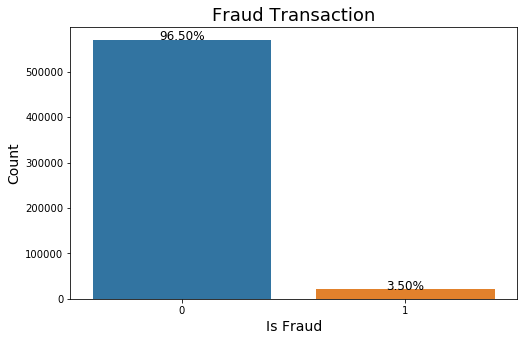

In [12]:
fig, ax  = plt.subplots(figsize=(8, 5))
sns.countplot(x='isFraud', data=train_transaction, ax=ax)
ax.set_title('Fraud Transaction', fontsize=18)
ax.set_xlabel('Is Fraud', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            f'{height/train_transaction.shape[0] * 100:.2f}%',
            ha='center', fontsize=12)


### TransactionDT

The `TransactionDT` feature is a timedelta from a given reference datetime (not an actual timestamp).
According to the [post](https://www.kaggle.com/c/ieee-fraud-detection/discussion/100071#latest-577632). The timespan of the dataset is around 1-year. 

We will look into the distrubtuion of both training and test set of `TransactionDT` feature

* The training and test transaction time do not overlap, which suggests training and test set are split by time. Also, there around a one-moth gap in between training and test set.

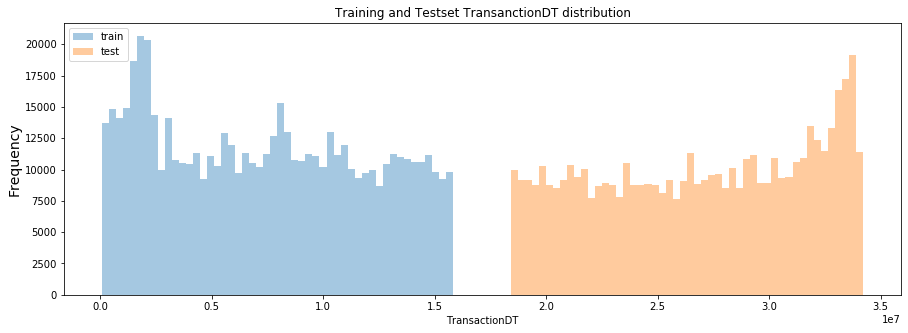

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(train_transaction['TransactionDT'], kde=False, ax=ax, label='train')
sns.distplot(test_transaction['TransactionDT'], kde=False, ax=ax, label='test')
ax.set_title('Training and Testset TransanctionDT distribution')
ax.set_ylabel('Frequency', fontsize=14)
ax.legend()

### TransactionAmt

* This feature is the Transaction amount in USD. The distrubtion of this feature is very skewed. So we will take the log transform to better view the distrubution. After applying log-transform, the fraud and non-fraud amount becomes normal distribution. 
* Moreover, most of the fraudent amount are generally lower the non-frauddent amount

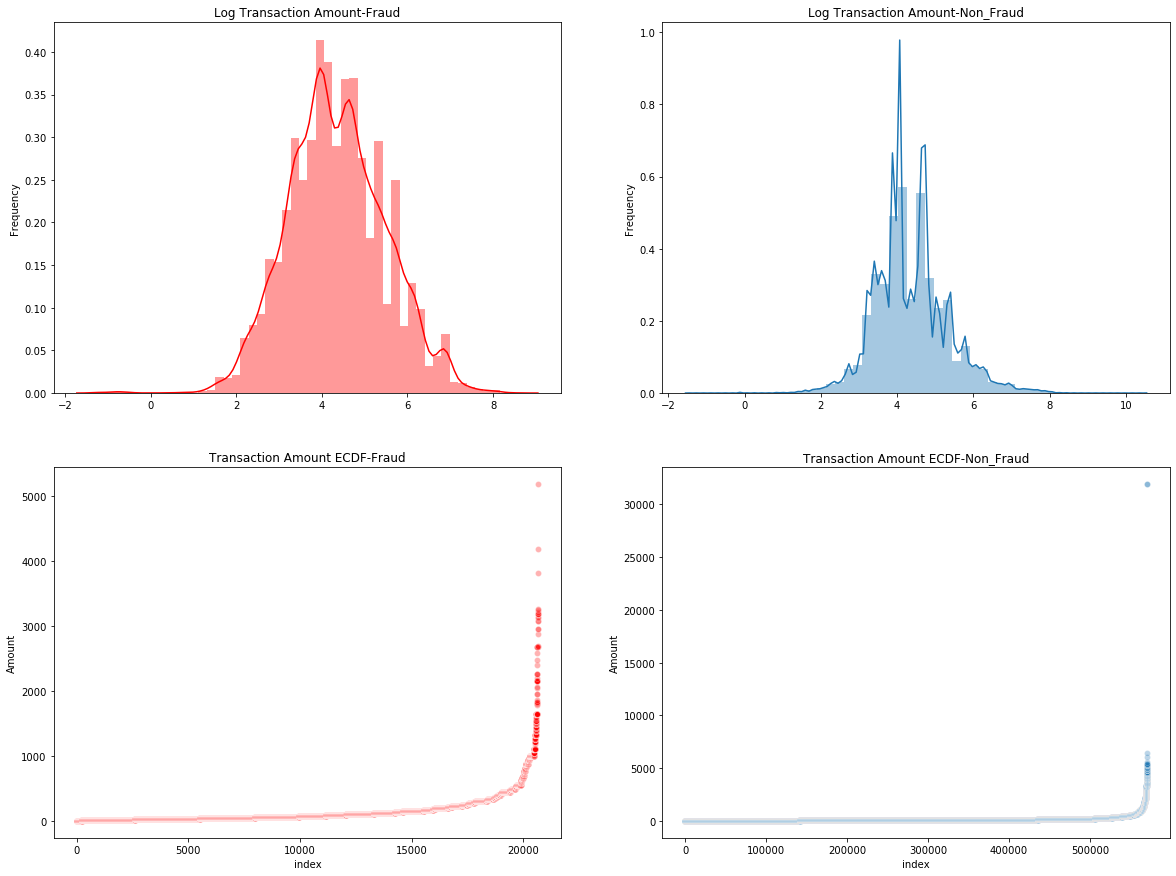

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

fraud_amt = train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values
non_fraud_amt = train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(fraud_amt), ax=ax[0][0], color='red')
ax[0][0].set_title("Log Transaction Amount-Fraud")
ax[0][0].set_ylabel("Frequency")

sns.distplot(np.log(non_fraud_amt), ax=ax[0][1])
ax[0][1].set_title("Log Transaction Amount-Non_Fraud")
ax[0][1].set_ylabel("Frequency")

sns.scatterplot(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
            np.sort(fraud_amt),
            alpha=0.3,
            color='red',
            ax=ax[1][0])
ax[1][0].set_title("Transaction Amount ECDF-Fraud")
ax[1][0].set_xlabel("index")
ax[1][0].set_ylabel("Amount")

sns.scatterplot(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
            np.sort(non_fraud_amt),
            alpha=0.3,
            ax=ax[1][1])
ax[1][1].set_title("Transaction Amount ECDF-Non_Fraud")
ax[1][1].set_xlabel("index")
ax[1][1].set_ylabel("Amount");

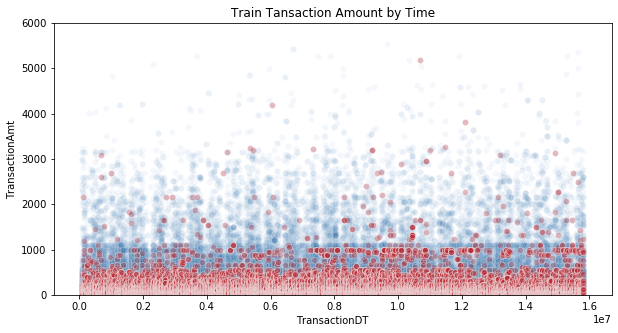

In [15]:
cmap=sns.color_palette("RdBu", n_colors=7)
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x=train_transaction['TransactionDT'],
                y=train_transaction['TransactionAmt'],
                alpha=0.05,
                color=cmap[6])
ax.set_title("Train Tansaction Amount by Time")
ax.set_xlabel("TransactionDT")
ax.set_ylabel("Amount in USD")
ax.set_ylim(0, 6000)

fraud_entries = train_transaction.loc[train_transaction['isFraud'] == 1]
sns.scatterplot(x=fraud_entries['TransactionDT'],
                y=fraud_entries['TransactionAmt'],
                alpha=0.3,
                color=cmap[0]);


### Product CD

ProductCD: product code, the product for each transaction.
* W is the most frequent value, followed by C and R.
* The percentage of fraud in product C is highest followed by S and H.

In [16]:
train_transaction['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [350]:
def fraud_dist(df, col_name):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.countplot(x=col_name, data=df, ax=ax[0])
    ax[0].set_title(col_name + ' Distribution', fontsize=14)
    ax[0].set_xlabel(col_name + ' Name', fontsize=10)
    ax[0].set_ylabel('Count', fontsize=14)
    for p in ax[0].patches:
        height = p.get_height()
        ax[0].text(p.get_x() + p.get_width()/2.,
                   height,
                   f'{height/train_transaction.shape[0] * 100:.2f}%',
                   ha='center', fontsize=10)

    df.groupby(col_name)['isFraud'].mean() \
        .sort_index() \
        .plot(kind='bar',
              ax=ax[1],
              title='Percentage of Fraud by ' + col_name,
              color=sns.color_palette())
    for p in ax[1].patches:
        height = p.get_height()
        ax[1].text(p.get_x() + p.get_width() / 2.,
                   height,
                   f'{height * 100:.2f}%',
                   ha='center', fontsize=10)

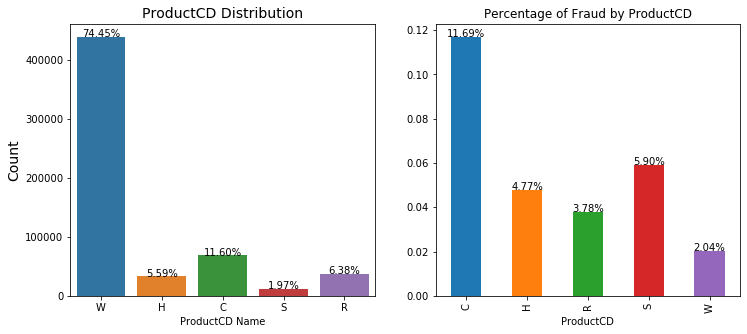

In [351]:
fraud_dist(train_transaction, 'ProductCD')

### Card Features

According to data description page from the competition, There are 6 different categorical card features `card1` to `card6`. However, `card1`, `card2`, `card3` and `card5` are encoded as numerical value. We are not told the exact features meaning for card features. This maybe payment card information, such as card type, card category etc. 

* Many values of card3 and card5 have low frequencies
* In card3, 150 and 185 are the most frequent values in the column. We have 2.4% of fraud in 150 and 13% of fraud in value 185
* In card5,  most frequent values are 226, 224, 166 that represents 73% of data.

In [21]:
resumetable(train_transaction[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


Name   dtypes  Missing  Uniques First Value Second Value Third Value
0  card1    int64        0    13553       13926         2755        4663
1  card2  float64     8933      500         NaN          404         490
2  card3  float64     1565      114         150          150         150
3  card4   object     1577        4    discover   mastercard        visa
4  card5  float64     4259      119         142          102         166
5  card6   object     1571        4      credit       credit       debit

In [22]:
train_transaction['card5'].value_counts().head()

226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
Name: card5, dtype: int64

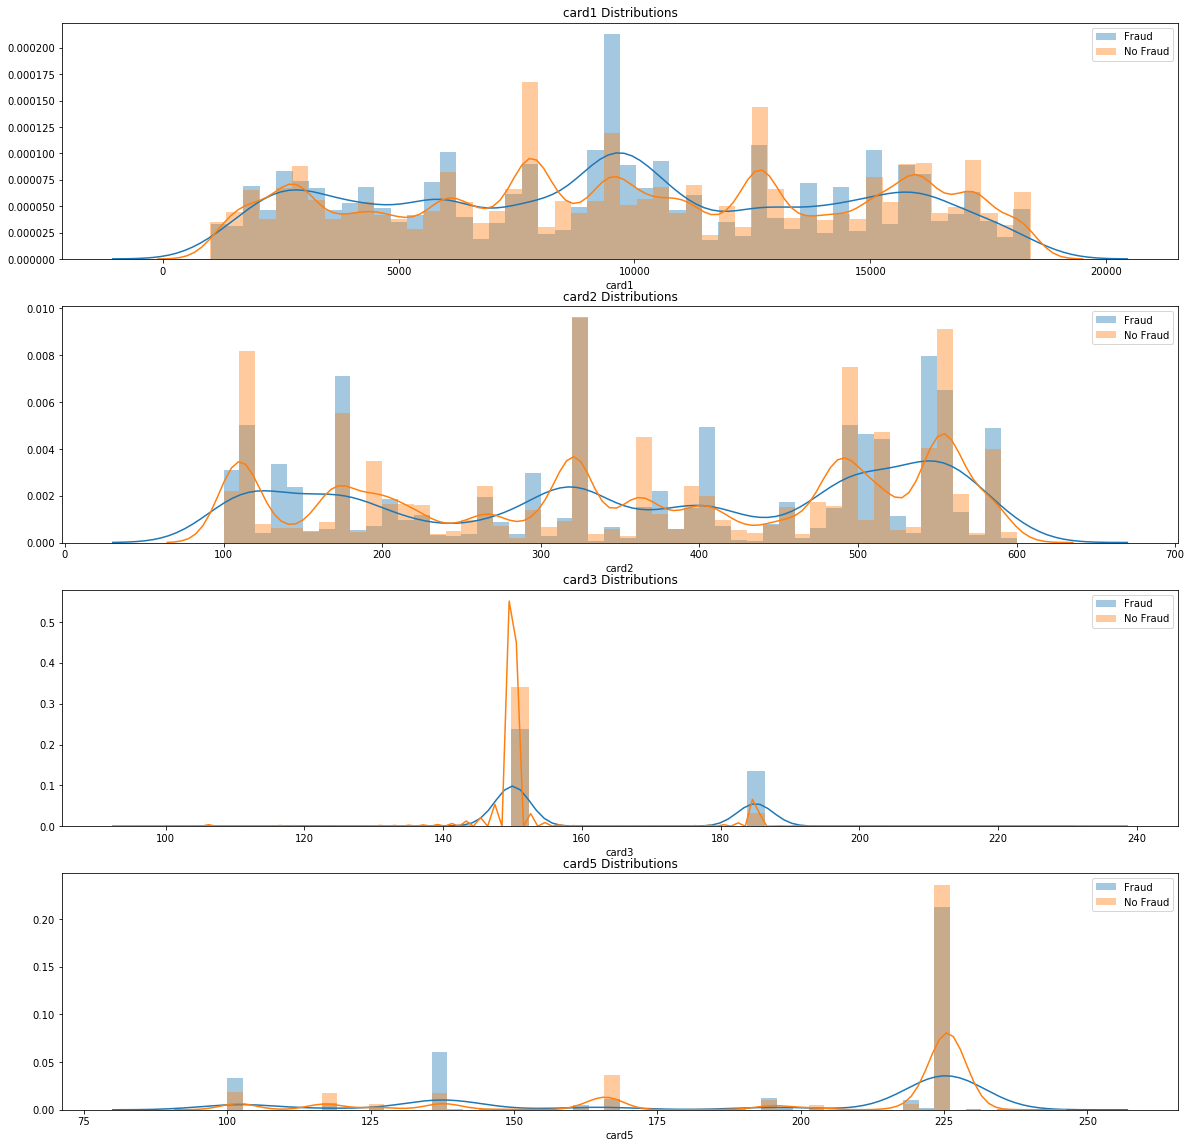

In [23]:
fig, ax = plt.subplots(4, figsize=(20, 20))
cards_col = train_transaction[['card1', 'card2', 'card3', 'card5']].columns
for i, card in enumerate(cards_col):
    sns.distplot(train_transaction[train_transaction['isFraud'] == 1][card],
                 bins=50,
                 ax=ax[i],
                 label='Fraud')
    sns.distplot(train_transaction[train_transaction['isFraud'] == 0][card],
                 bins=50,
                 ax=ax[i],
                 label='No Fraud')
    
    ax[i].legend()
    ax[i].set_title(str(card) + " Distributions")

#### Card 4

* 97.2% of data are either mastercard or visa
* Out of all the card types, discover card (around 8%) has highest percentage of fraud followed by (3.5%) mastercard and visa  

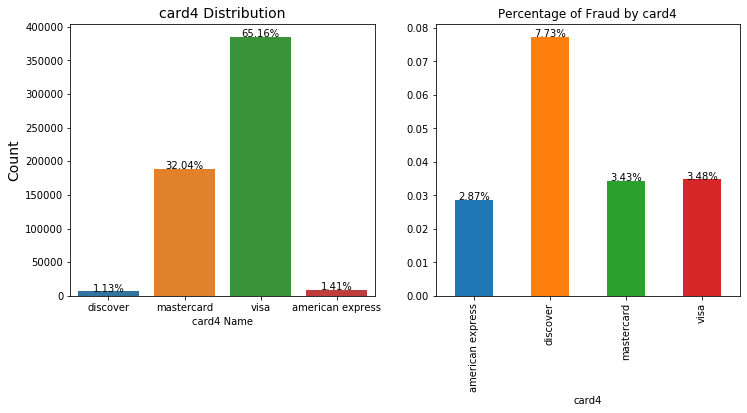

In [321]:
fraud_dist(train_transaction, 'card4')

#### Card 6

* 99.73% of data are either credit or debit card. The percentage of fraud for credit card (6.5%) is much higher than debit card (2.5%)

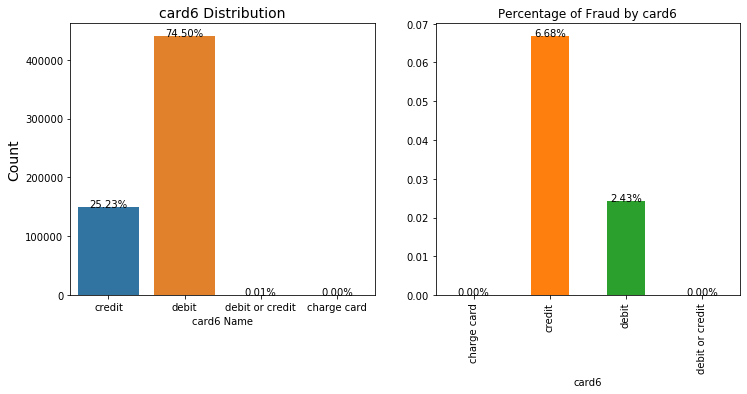

In [322]:
fraud_dist(train_transaction, 'card6')

### Addr

* Data description page suggests that both values are categorical. But these are float64 type. This means the data provider use some sort of encoding to represent each transaction's address.
* Address of transactions

In [31]:
resumetable(train_transaction[['addr1', 'addr2']])

Dataset Shape: (590540, 2)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value
0  addr1  float64    65706      332        315.0         325.0        330.0
1  addr2  float64    65706       74         87.0          87.0         87.0

* around 82.9% of data in `addr1` is in the highest 35 unique values. The rest can grouped into one category "others"
* around 88% of data in `addr2` is cluster in 5 unique values. Values with less than 80 entries will group into category "Others" 

In [44]:
(train_transaction['addr1'].value_counts().head(35) / train_transaction['addr1'].shape[0] * 100).sum()

82.91208046872354

In [55]:
(train_transaction['addr2'].value_counts().head(5)  / train_transaction['addr2'].shape[0] * 100).sum()

88.79601720459242

In [78]:
train_transaction.loc[train_transaction.addr1.\
                      isin(train_transaction.addr1.value_counts()\
                           [train_transaction.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train_transaction.loc[train_transaction.addr2. \
                      isin(train_transaction.addr2.value_counts()\
                           [train_transaction.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

In [80]:
resumetable(train_transaction[['addr1', 'addr2']])

Dataset Shape: (590540, 2)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0  addr1  object    65706       31         315          325         330
1  addr2  object    65706        7          87           87          87

In [265]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
def count_fraud_plot(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)

    fig, ax = plt.subplots(nrows=2, figsize=(15, 10))
    sns.countplot(x=col, data=train_transaction,
                  order=list(tmp[col].values), ax=ax[0])
    
    #ax[0].set_xlabel(f"{col} Category Names", fontsize=12)
    ax[0].set_title(
        f"Frequency of {col} values", fontsize=16)
    ax[0].set_ylabel("Count", fontsize=12)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

    for p in ax[0].patches:
        height = p.get_height()
        ax[0].text(p.get_x()+p.get_width()/2.,
                   height,
                   f'{height/train_transaction.shape[0] * 100:.2f}%',
                   ha='center', fontsize=8)
    
    sns.barplot(x=col, y='Fraud', data=tmp,
                  order=list(tmp[col].values), ax=ax[1])
    
    ax[1].set_xlabel(f"{col} Category Names", fontsize=12)
    ax[1].set_title(
        f"Fraud Percentage of {col} values", fontsize=16)
    ax[1].set_ylabel("Percent", fontsize=12)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
    plt.subplots_adjust(hspace=.4, top = 0.9)
    
    for p in ax[1].patches:
        height = p.get_height()
        ax[1].text(p.get_x()+p.get_width()/2.,
                   height,
                   f'{height:.2f}%',
                   ha='center', fontsize=8)
    plt.subplots_adjust(hspace=.4, top = 1.1)
    plt.show();

In [263]:
def amt_fraud_plot(df, col):
    percent_amt = (df.groupby(['isFraud', col])['TransactionAmt'].sum()
                   / df.groupby([col])['TransactionAmt'].sum() * 100). \
        unstack('isFraud')
    percent_amt = percent_amt.reset_index()
    percent_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    
    fig, ax = plt.subplots(nrows=2, figsize=(15, 10))
    sns.barplot(x=col, y='TransactionAmt',
                data=amt,
                order=list(percent_amt[col].values),
                ax=ax[0])
    
    
    #ax[0].set_xlabel(f"{col} Category Names", fontsize=12)
    ax[0].set_title(
        f"{col} Transaction amounts", fontsize=16)
    ax[0].set_ylabel("Transaction Amount (USD)", fontsize=12)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
    total_amt = df['TransactionAmt'].sum()
    for p in ax[0].patches:
        height = p.get_height()
        ax[0].text(p.get_x()+p.get_width()/2.,
                   height,
                   f'{height / total_amt  * 100:.2f}%',
                   ha='center', fontsize=8)
        
    sns.barplot(x=col, y='Fraud', data=percent_amt,
                  order=list(percent_amt[col].values), ax=ax[1])
    
    ax[1].set_xlabel(f"{col} Category Names", fontsize=12)
    ax[1].set_title(
        f"Fraud Percentage of {col} values", fontsize=16)
    ax[1].set_ylabel("Percent", fontsize=12)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
    plt.subplots_adjust(hspace=.4, top = 0.9)
    
    for p in ax[1].patches:
        height = p.get_height()
        ax[1].text(p.get_x()+p.get_width()/2.,
                   height,
                   f'{height:.2f}%',
                   ha='center', fontsize=8);
    plt.show();

#### Addr1

* The value 299.0 (7.85%), 325.0 (7.24%), 204.0(7.12) 264.0(6.75%) occur more frequently than any other unqiue values
* However, the fraud percentage seems to suggest that the lower frequency groups has higher fraud percentage than the higher frequency values
 

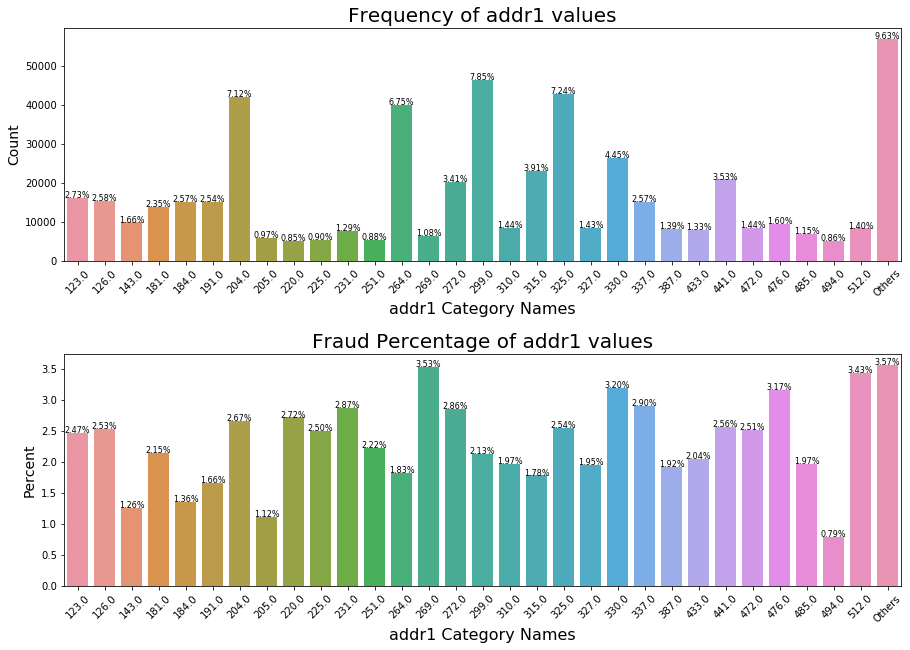

In [205]:
count_fraud_plot(train_transaction, 'addr1')

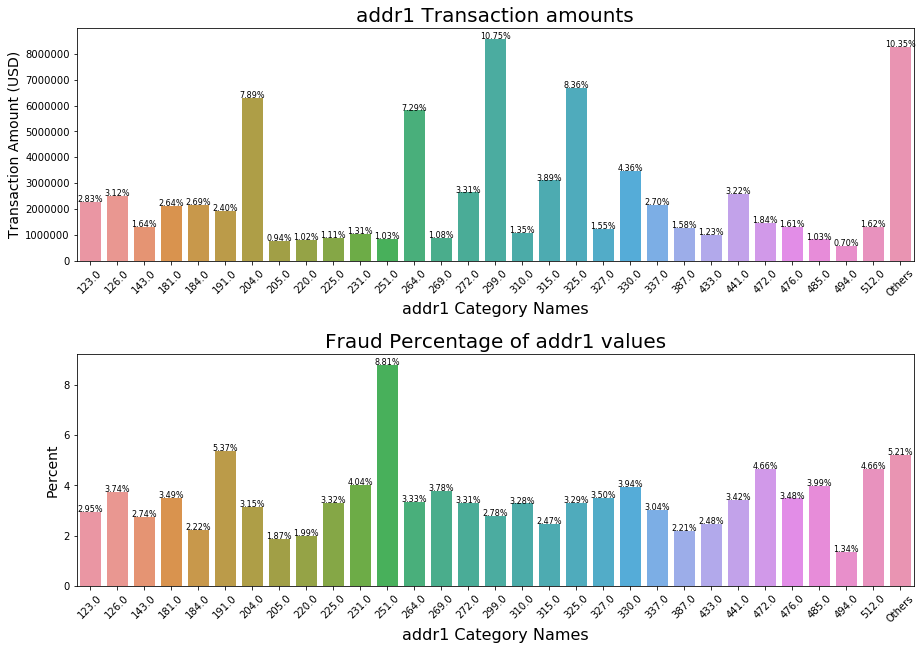

In [206]:
amt_fraud_plot(train_transaction, 'addr1')

#### Addr2

* The values 87 has around 88% of total transactions. Morever, the value 87 has 96% of Total transaction amounts in USD.
* As with Addr1, it seems like the lower frequency groups has higher fraud percentage. Especailly the value 65.0, it only has around 0.01% of entries but with a whooping 53% fraud percentage.

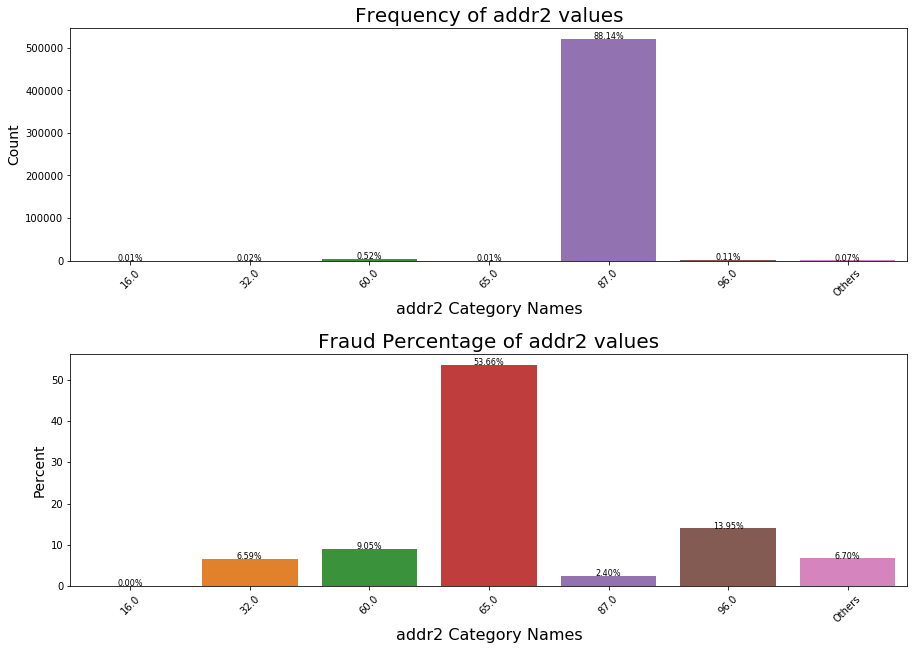

In [200]:
count_fraud_plot(train_transaction, 'addr2')

posx and posy should be finite values
posx and posy should be finite values


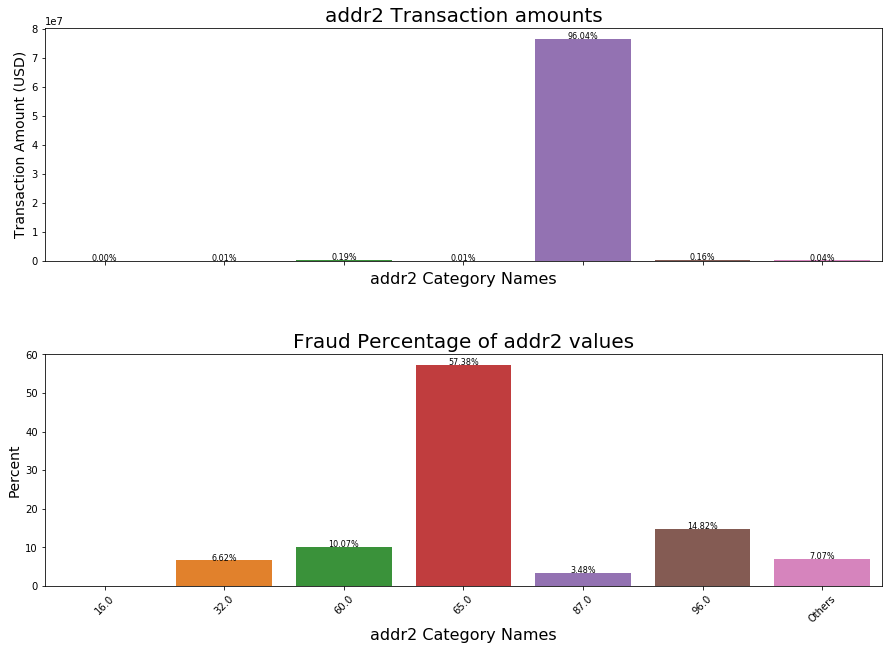

In [201]:
amt_fraud_plot(train_transaction, 'addr2')

### P_emaildomain	& R_emaildomain

* P_emaildomain is the purchaser email domain and R_emaildomain is the recipient email domain
* group email domains by the service provider and grouped domains that have less than 1000entries as 'Others
* Most of the transaction's P_emaildomain are from Google, Yahoo and Microsoft.
* Microsoft P_emaildomain has the highest fraud percentage in comparsion to other domain.
* Most of the transaction's R_emaildomain are from Google, anonymous mail, Yahoo and Microsoft.
* R_emaildomain has more missing values than P_emaildomain. Apple mail, google and microwoft haave highter frauds than other domains

In [268]:
def group_email_domain(df):
    
    for email in ['P_emaildomain', 'R_emaildomain']:
        
        df.loc[df[email].
               isin(['gmail.com', 'gmail']), email] = 'Google Mail'
        df.loc[df[email].
               isin(['yahoo.com', 'ymail.com', 'yahoo.com.mx',
                     'yahoo.co.jp', 'yahoo.fr', 'yahoo.co.uk',
                     'yahoo.es', 'yahoo.de']), email] = 'Yahoo Mail'
        df.loc[df[email].
               isin(['hotmail.com', 'outlook.com', 'msn.com',
                     'live.com', 'live.com.mx', 'outlook.es',
                     'hotmail.fr', 'hotmail.co.uk', 'live.fr',
                     'hotmail.es', 'hotmail.de']), email] = 'Microsoft mail'
        df.loc[df[email].
               isin(['icloud.com', 'me.com', 'mac.com']), email] = 'Apple mail'

        df.loc[df[email].
               isin(train_transaction[email].
                    value_counts()[train_transaction[email].
                    value_counts() <= 1000].index), email] = 'Others'
    return df

In [277]:
train_transaction = group_email_domain(train_transaction)

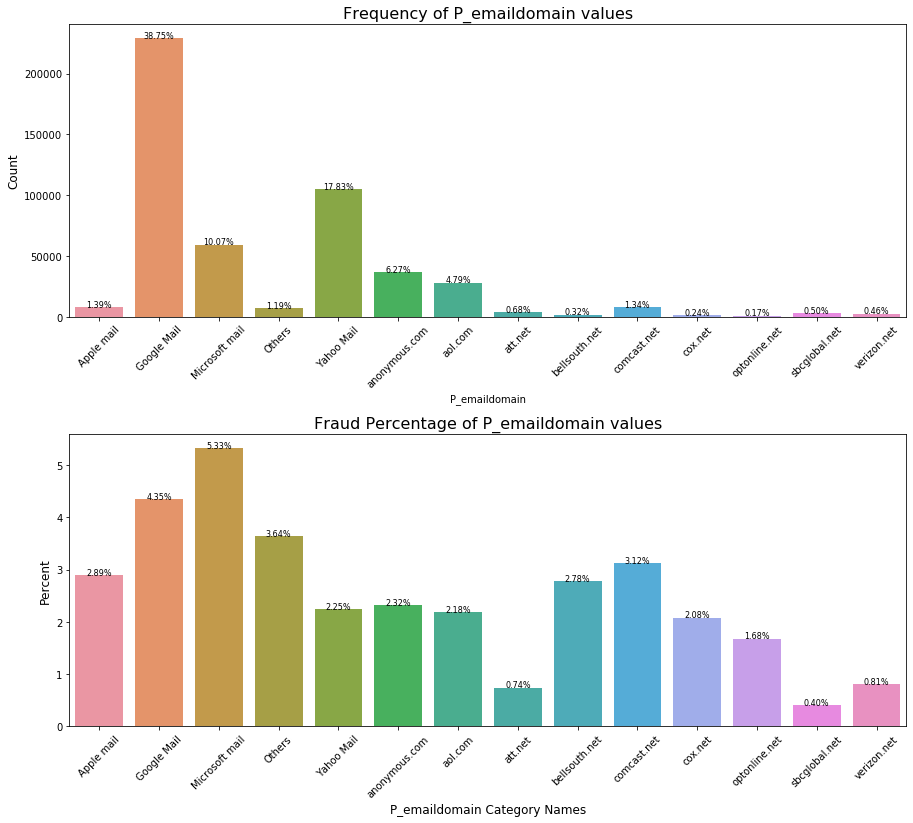

In [278]:
count_fraud_plot(train_transaction, 'P_emaildomain')

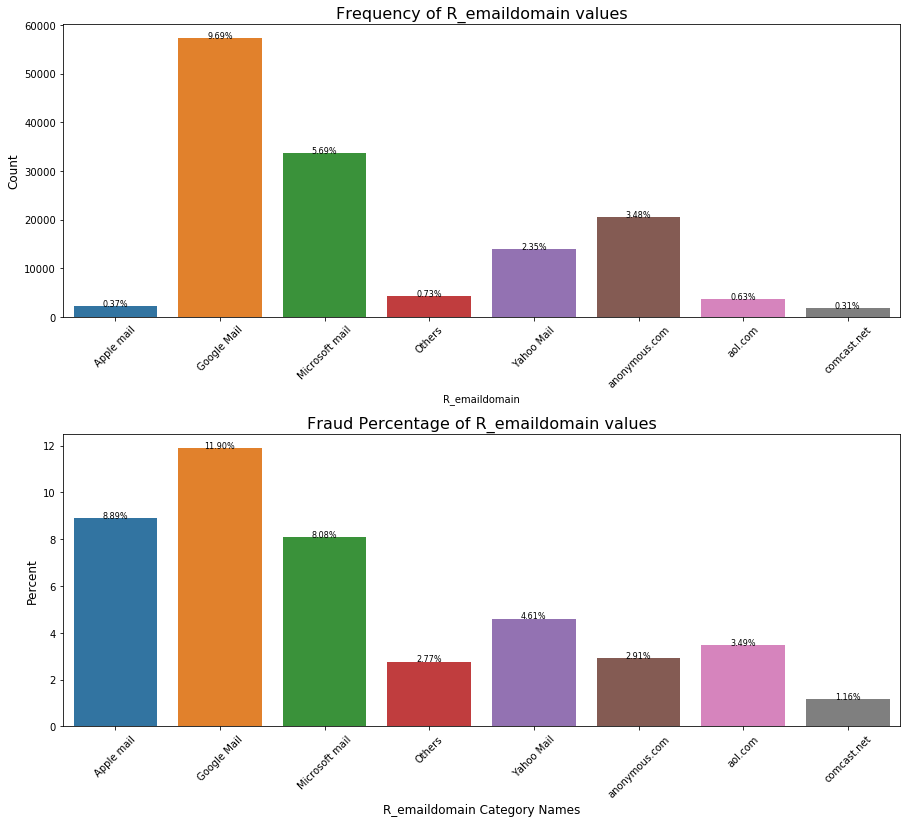

In [279]:
count_fraud_plot(train_transaction, 'R_emaildomain')

#### C1-C14 features

* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* Except for C3 which has significant more count than the other C features. The rest of C features exhibit the same sort of year paterns. As we mentioned earlier, when the training and test set are combined, we have 1 year and one month of data with a gap of 30 days around middle of the year. The explained the visual changes at the start and towards the end of `TransactionDT`. 

In [281]:
resumetable(train_transaction.iloc[:,17:31])

Dataset Shape: (590540, 14)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value
0    C1  float64        0     1657          1.0           1.0          1.0
1    C2  float64        0     1216          1.0           1.0          1.0
2    C3  float64        0       27          0.0           0.0          0.0
3    C4  float64        0     1260          0.0           0.0          0.0
4    C5  float64        0      319          0.0           0.0          0.0
5    C6  float64        0     1328          1.0           1.0          1.0
6    C7  float64        0     1103          0.0           0.0          0.0
7    C8  float64        0     1253          0.0           0.0          0.0
8    C9  float64        0      205          1.0           0.0          1.0
9   C10  float64        0     1231          0.0           0.0          0.0
10  C11  float64        0     1476          2.0           1.0          1.0
11  C12  float64        0     1199          0.0           0.0          0.0
12  C13  float64        0     1597          1.0           1.0          1.0
13  C14  float64        0     1108          1.0           1.0          1.0

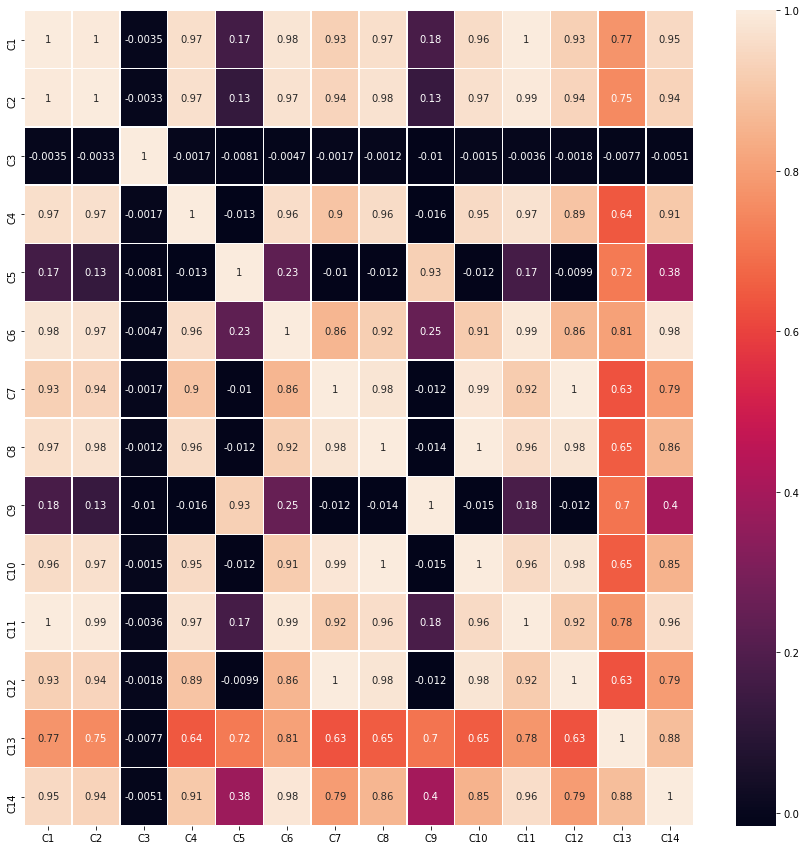

In [303]:
corr = train_transaction.iloc[:, 17:31].corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, linewidths=.5, annot=True, ax=ax)

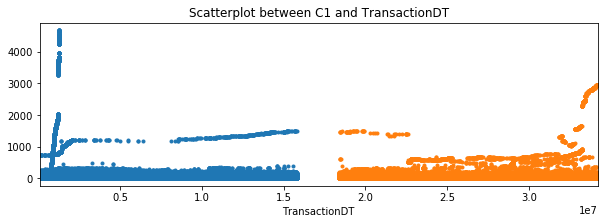

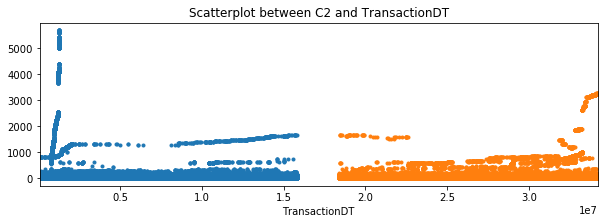

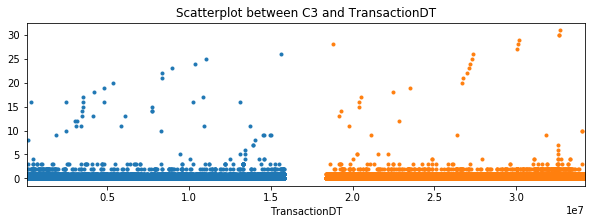

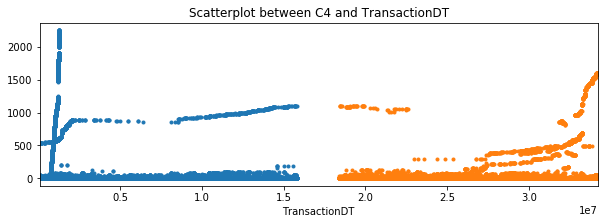

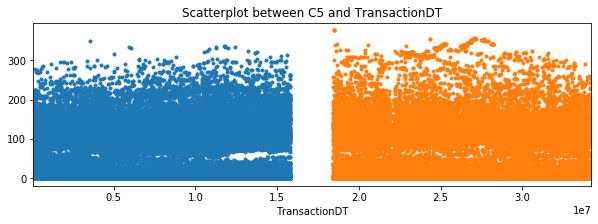

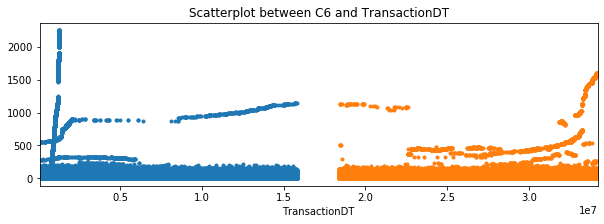

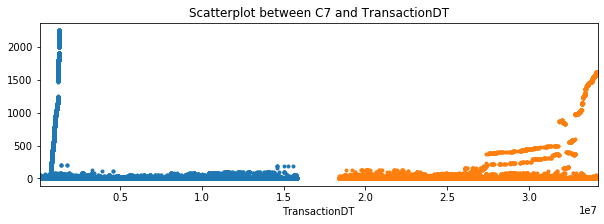

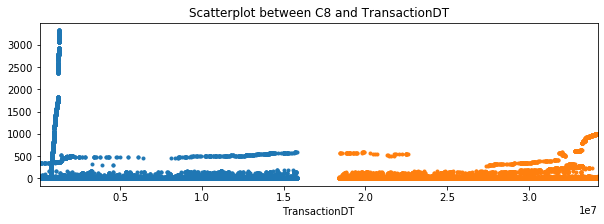

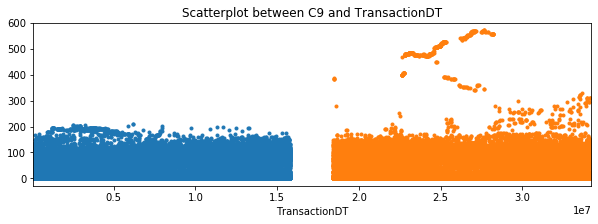

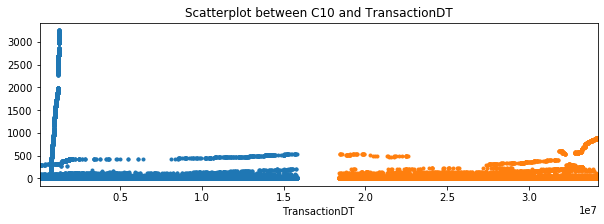

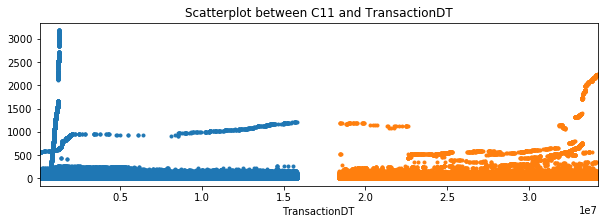

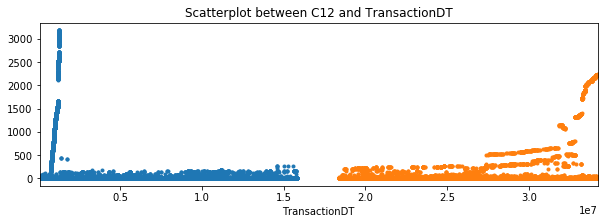

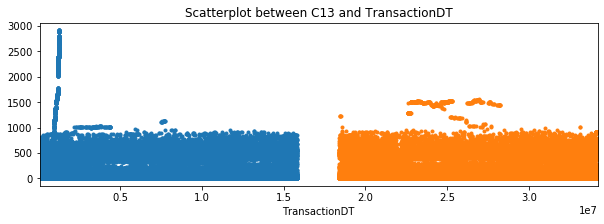

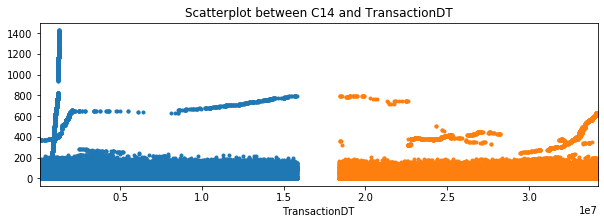

In [312]:
c_features = list(train_transaction.columns[17:31])
for i in c_features:
    train_transaction.set_index('TransactionDT')[i] \
    .plot(style='.', title=f'Scatterplot between {i} and TransactionDT',
          figsize=(10, 3))
    test_transaction.set_index('TransactionDT')[i] \
    .plot(style='.', figsize=(10, 3))
    plt.show()
                                                         

### D1-D15

* D1-D15: timedelta, such as days between previous transaction, etc.
* Except for D1, D2, D9, it shows increasing trends over the years

In [297]:
resumetable(train_transaction.iloc[:, 31:46])

Dataset Shape: (590540, 15)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value
0    D1  float64     1269      641         14.0           0.0          0.0
1    D2  float64   280797      641          NaN           NaN          NaN
2    D3  float64   262878      649         13.0           NaN          NaN
3    D4  float64   168922      808          NaN           0.0          0.0
4    D5  float64   309841      688          NaN           NaN          NaN
5    D6  float64   517353      829          NaN           NaN          NaN
6    D7  float64   551623      597          NaN           NaN          NaN
7    D8  float64   515614    12353          NaN           NaN          NaN
8    D9  float64   515614       24          NaN           NaN          NaN
9   D10  float64    76022      818         13.0           0.0          0.0
10  D11  float64   279287      676         13.0           NaN        315.0
11  D12  float64   525823      635          NaN           NaN          NaN
12  D13  float64   528588      577          NaN           NaN          NaN
13  D14  float64   528353      802          NaN           NaN          NaN
14  D15  float64    89113      859          0.0           0.0        315.0

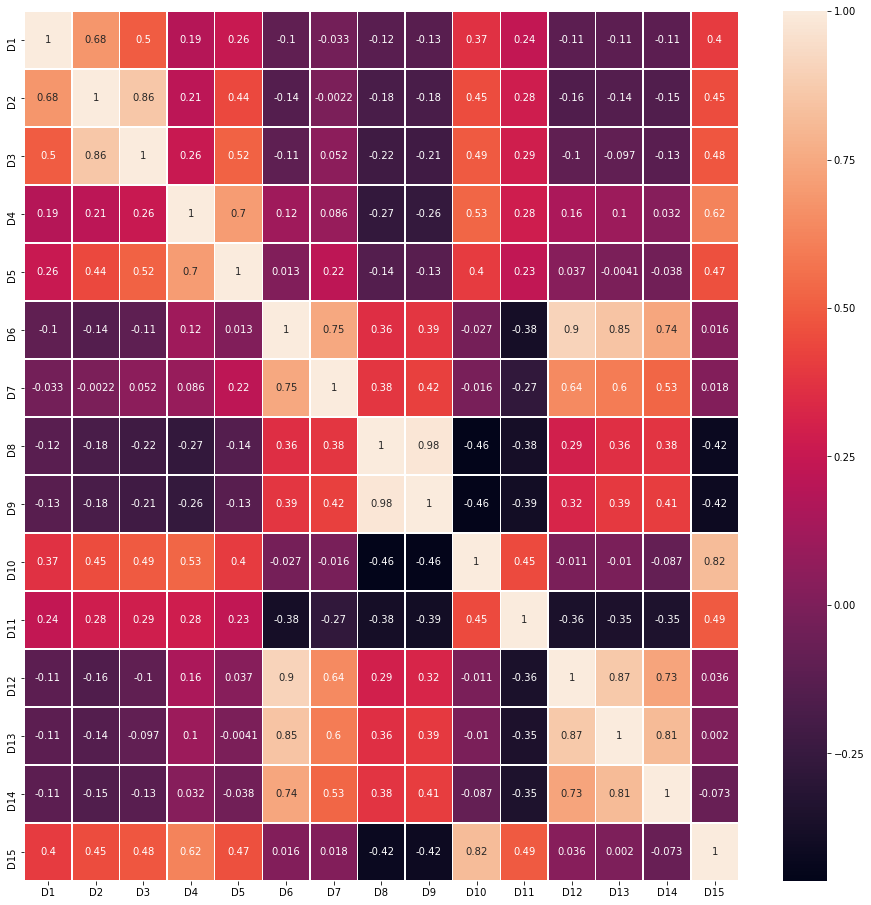

In [311]:
d_features = list(train_transaction.columns[31:46])
corr = train_transaction[d_features].fillna(-999).corr()
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, linewidths=.5, annot=True, ax=ax);

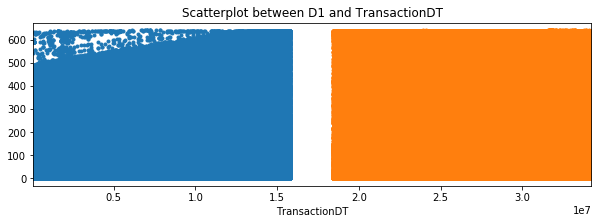

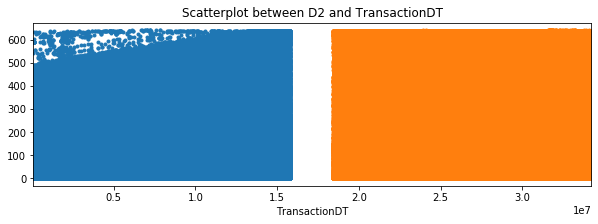

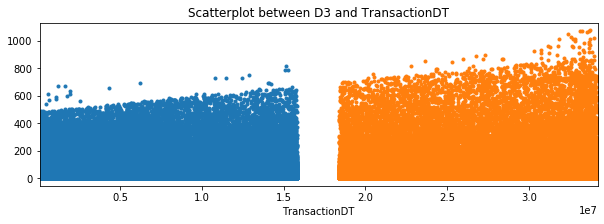

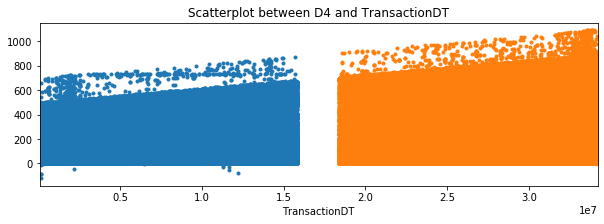

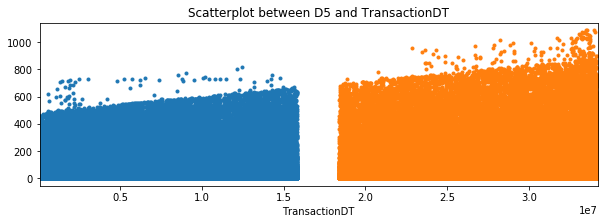

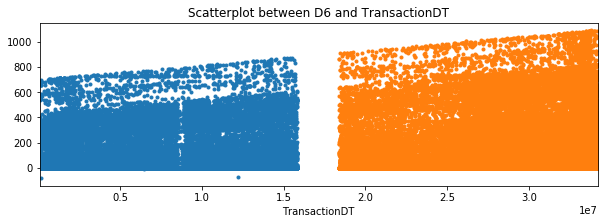

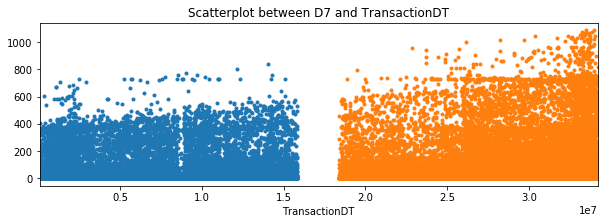

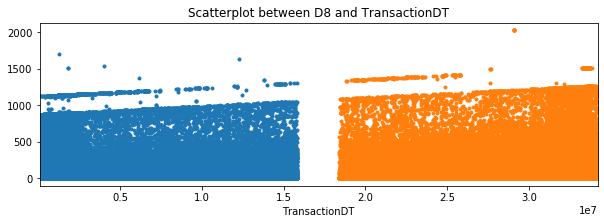

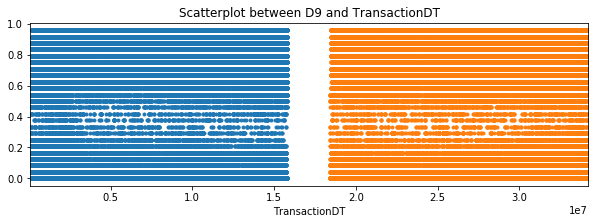

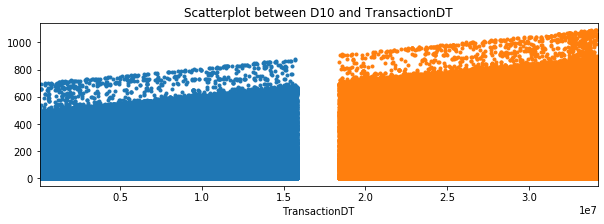

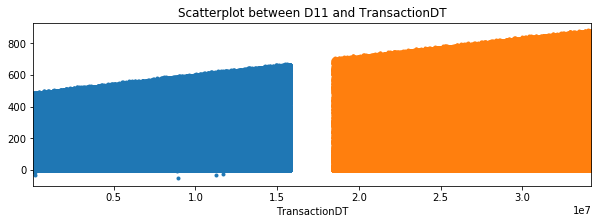

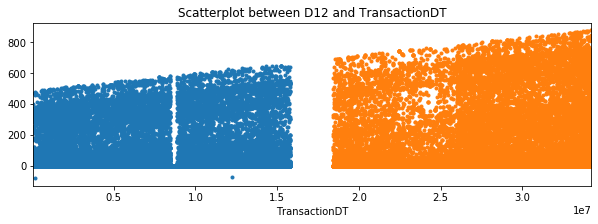

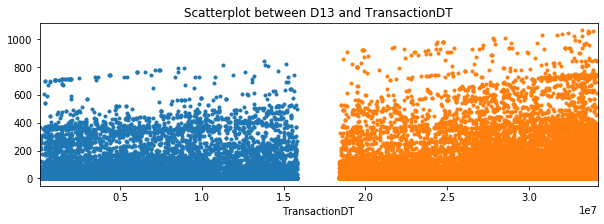

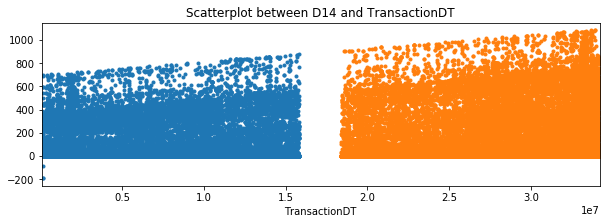

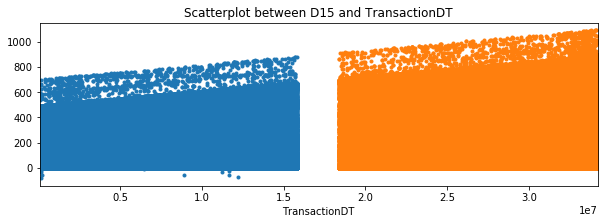

In [314]:
d_features = list(train_transaction.columns[31:46])
for i in d_features:
    train_transaction.set_index('TransactionDT')[i].fillna(0) \
    .plot(style='.', title=f'Scatterplot between {i} and TransactionDT',
          figsize=(10, 3))
    test_transaction.set_index('TransactionDT')[i].fillna(0) \
    .plot(style='.', figsize=(10, 3))
    plt.show()
    

### M1-M9

* M1-M9: match, such as names on card and address, etc.
* Values are `T`, `F` or `NaN`. Except for `M4` which has values such as M0, M1 and M2.
* Features M2 and M6 have less % of missing values than the other M features.
* Except M4, all the other features missing value has the higest fraud percentage 

In [316]:
resumetable(train_transaction.iloc[:, 46:55])


Dataset Shape: (590540, 9)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0   M1  object   271100        2           T          NaN           T
1   M2  object   271100        2           T          NaN           T
2   M3  object   271100        2           T          NaN           T
3   M4  object   281444        3          M2           M0          M0
4   M5  object   350482        2           F            T           F
5   M6  object   169360        2           T            T           F
6   M7  object   346265        2         NaN          NaN           F
7   M8  object   346252        2         NaN          NaN           F
8   M9  object   346252        2         NaN          NaN           F

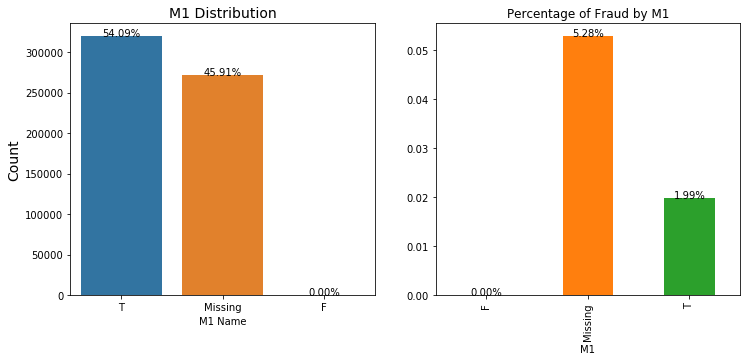

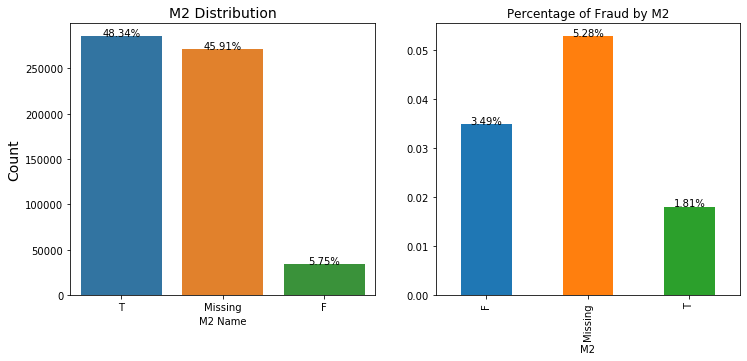

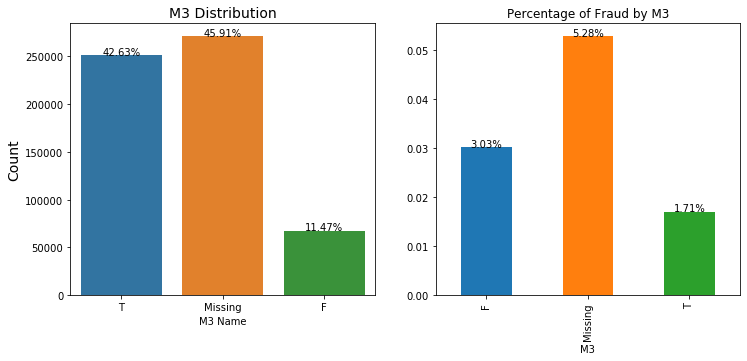

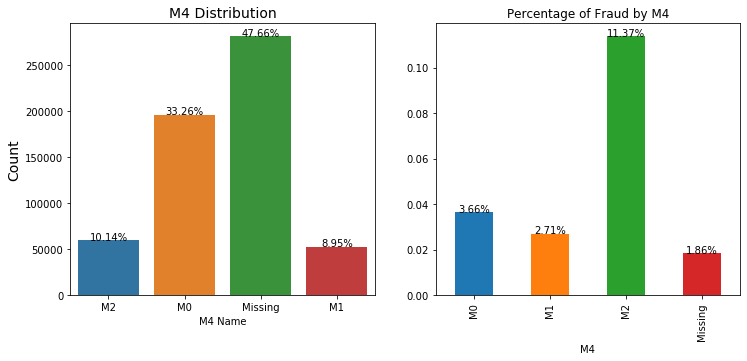

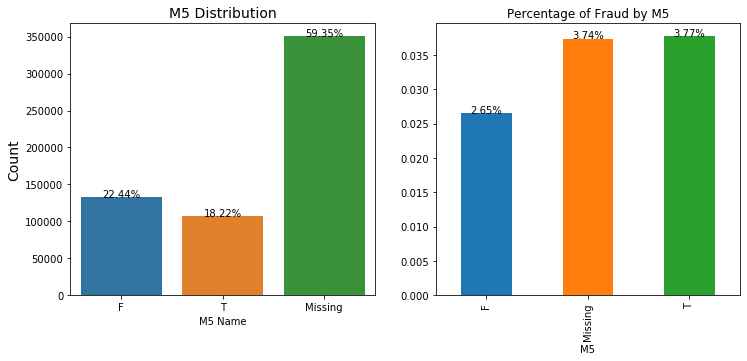

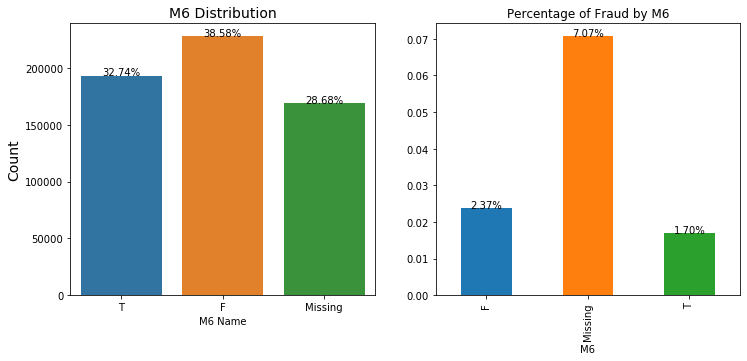

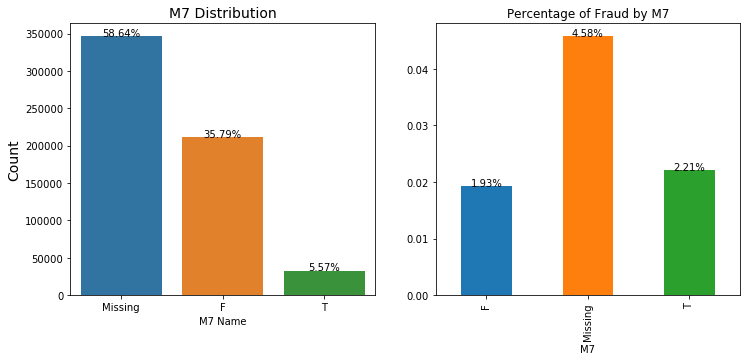

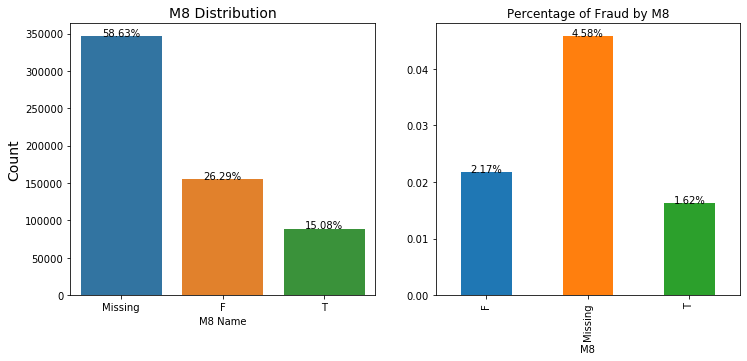

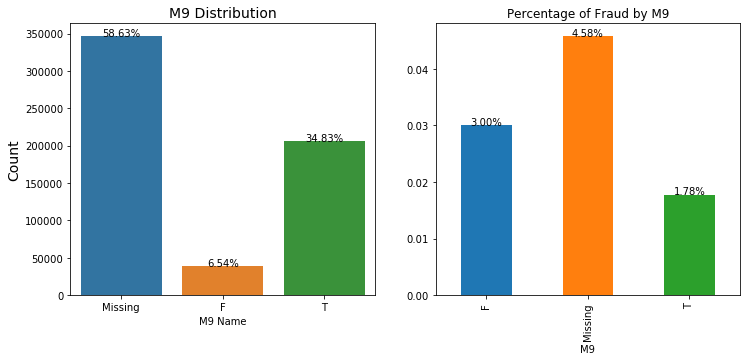

In [353]:
for col in m_features:
    train_transaction[col] = train_transaction[col].fillna('Missing')
    fraud_dist(train_transaction, col)

### V1-V339

V features: Vesta engineered rich features, including ranking, counting, and other entity relations. numerical feature
* Many of the V features has missing values


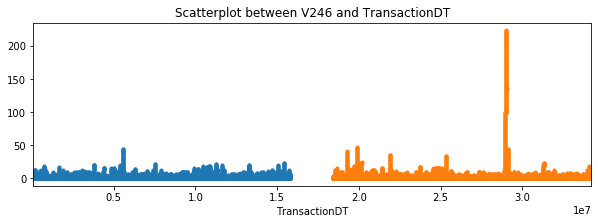

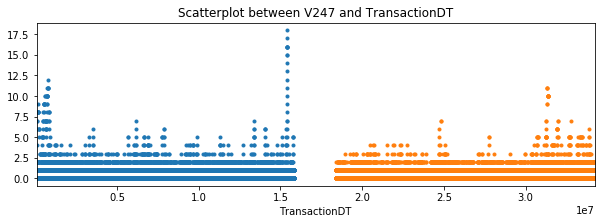

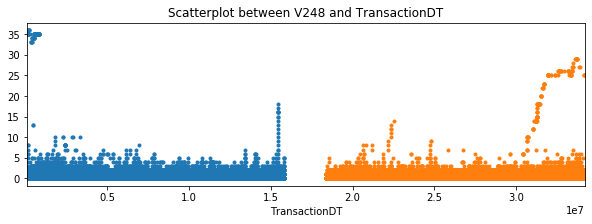

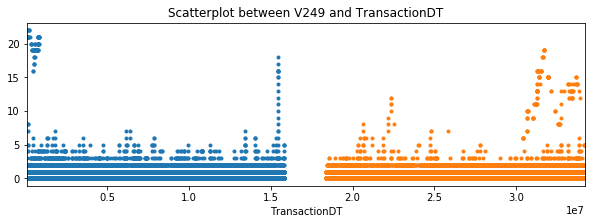

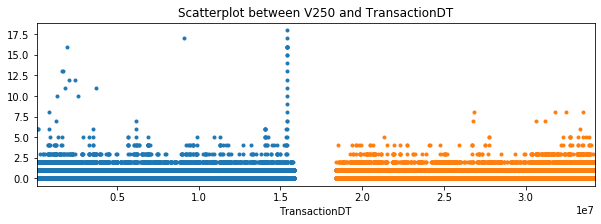

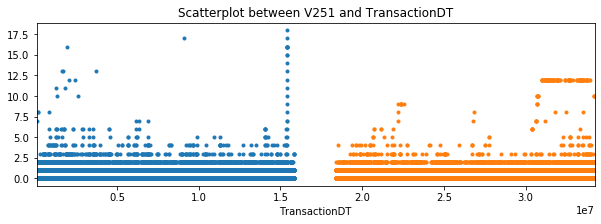

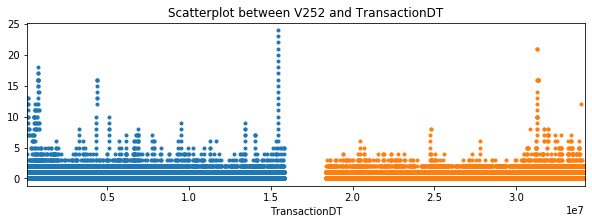

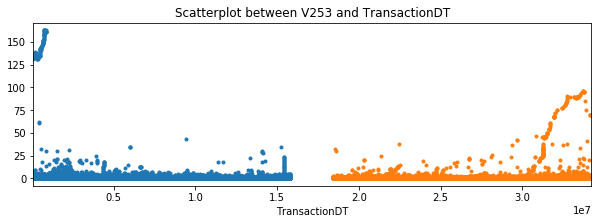

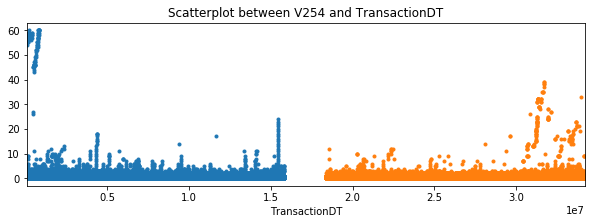

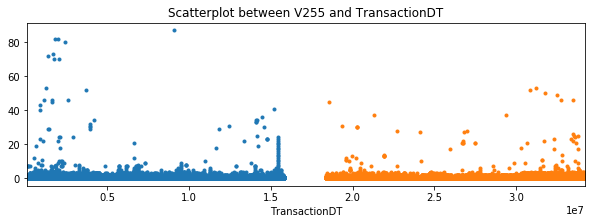

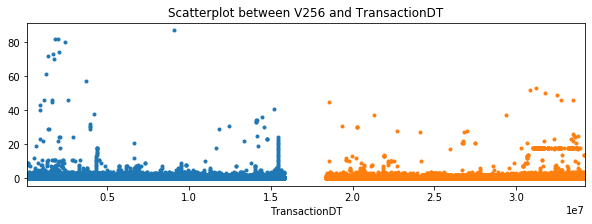

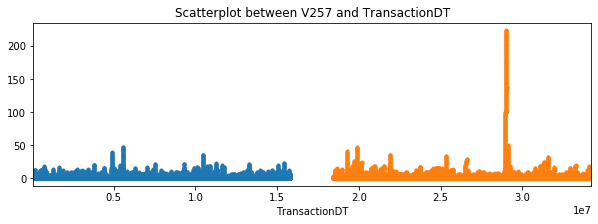

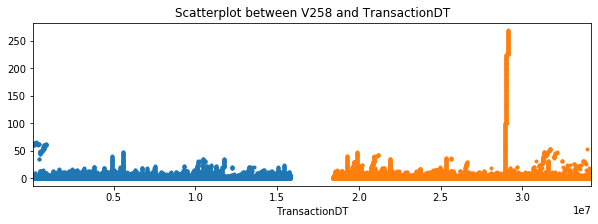

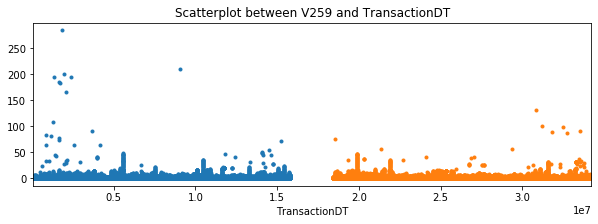

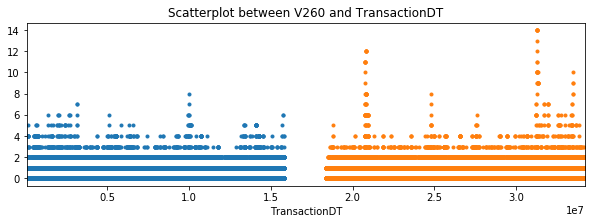

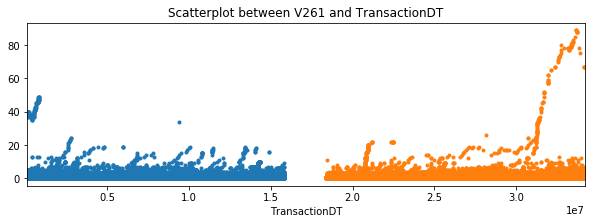

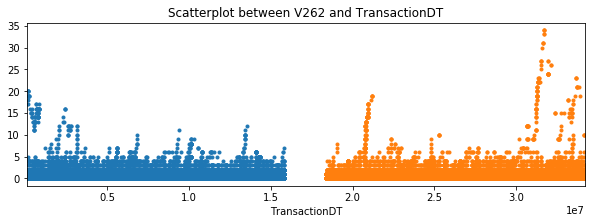

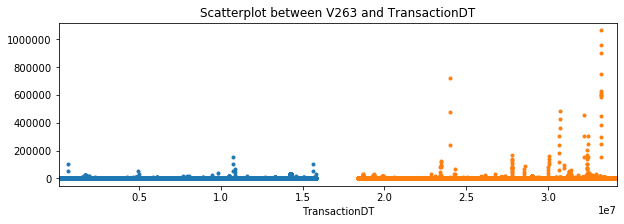

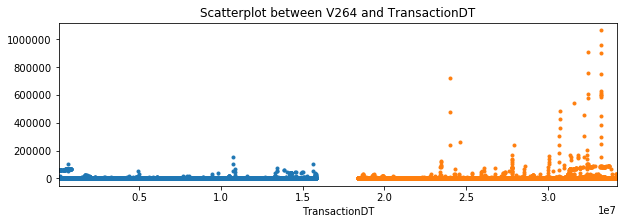

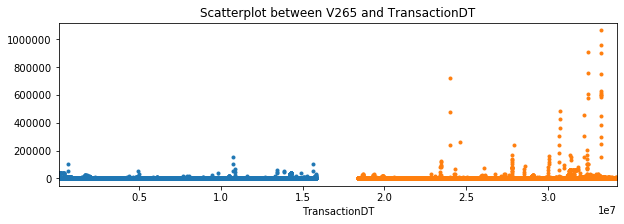

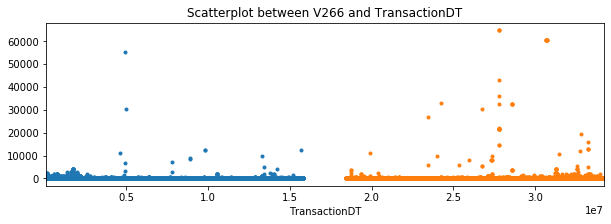

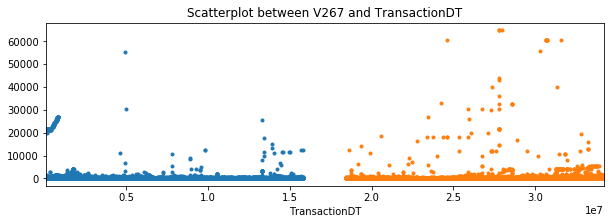

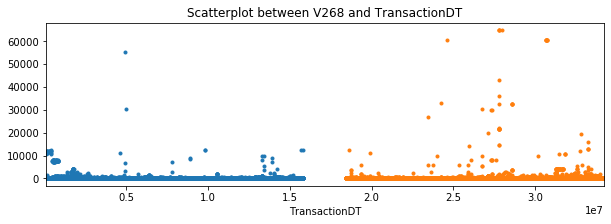

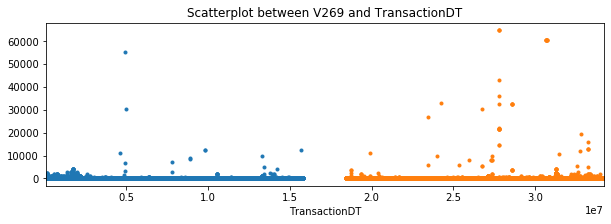

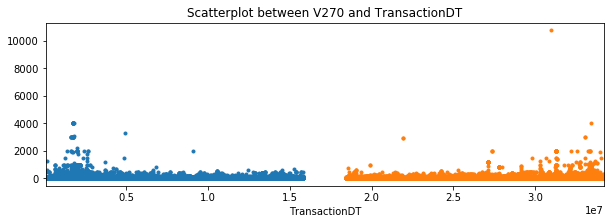

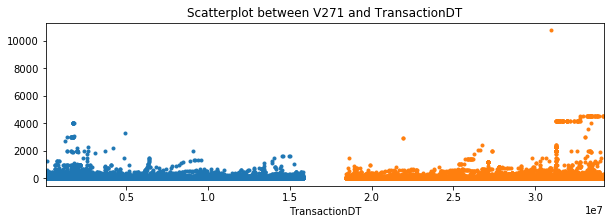

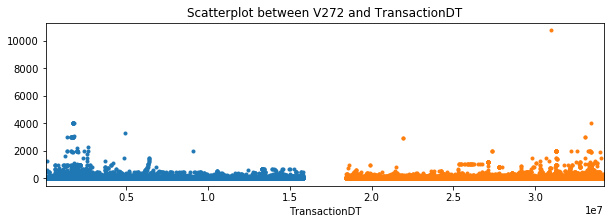

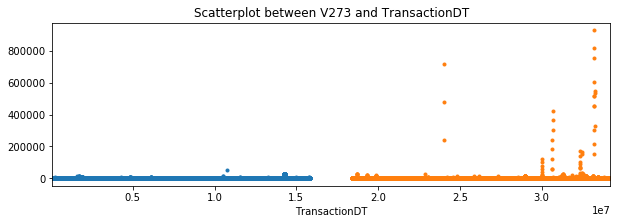

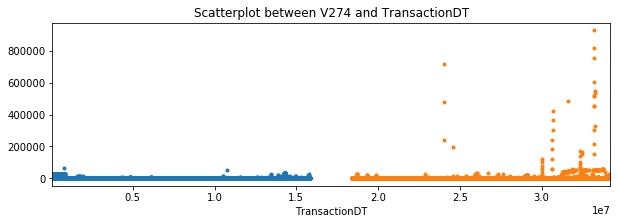

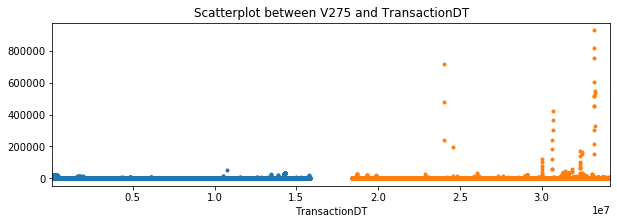

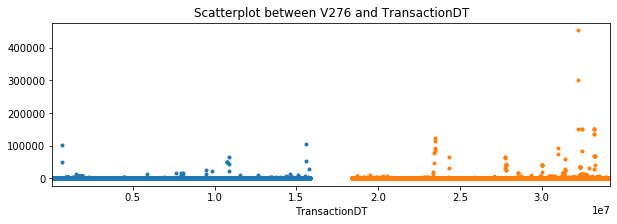

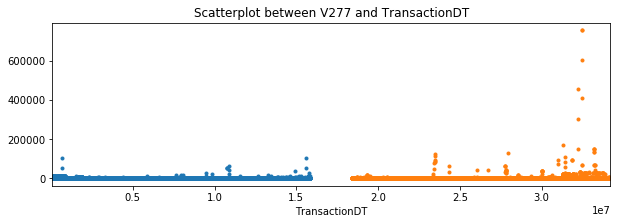

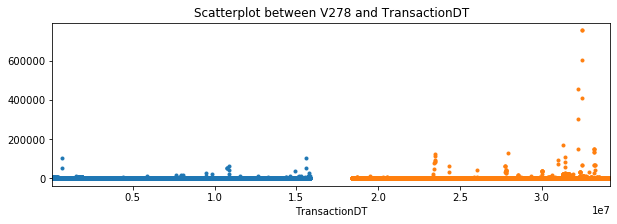

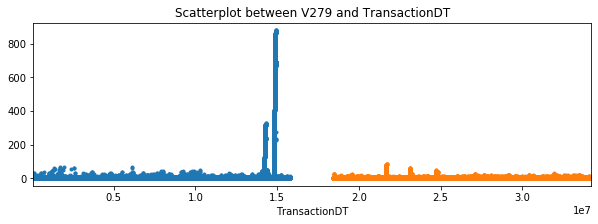

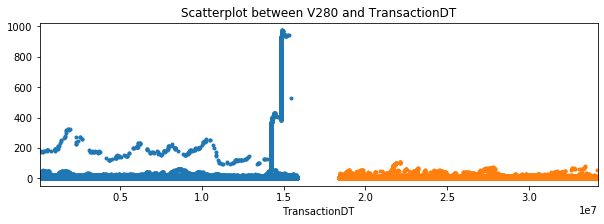

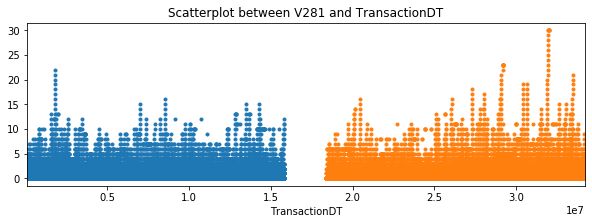

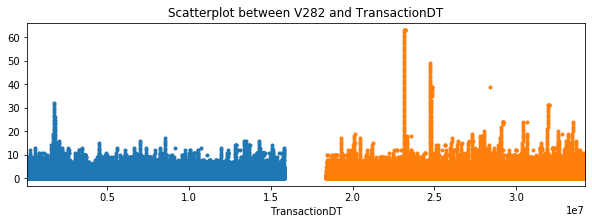

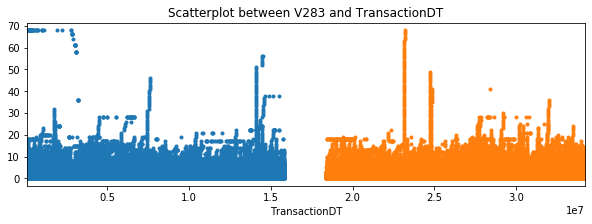

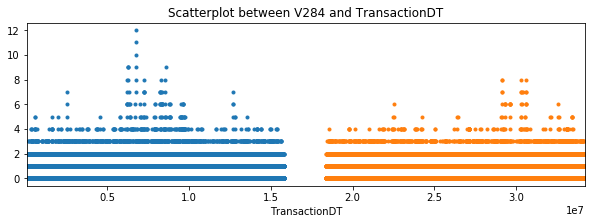

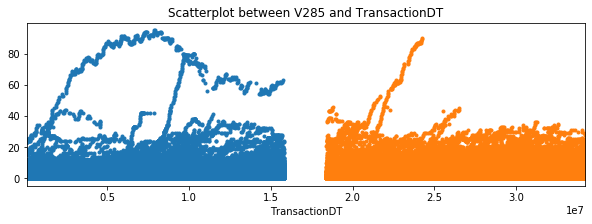

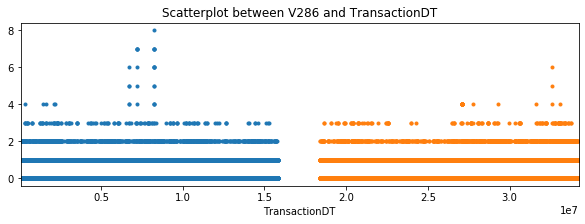

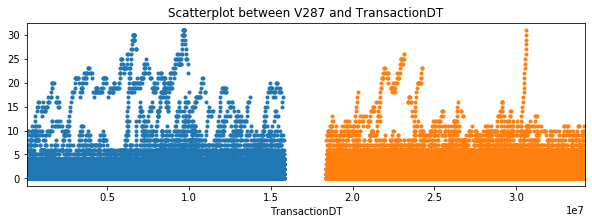

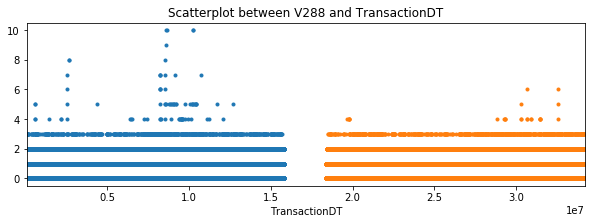

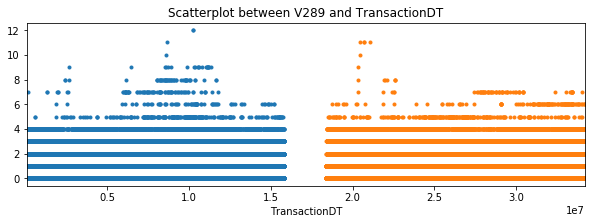

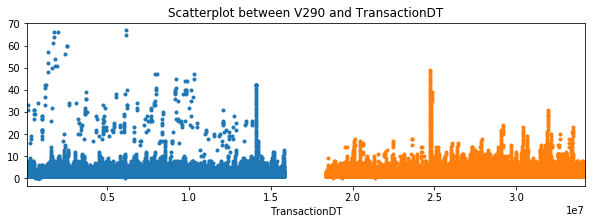

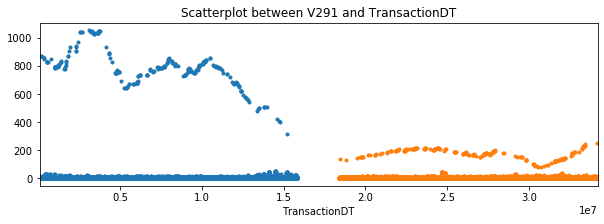

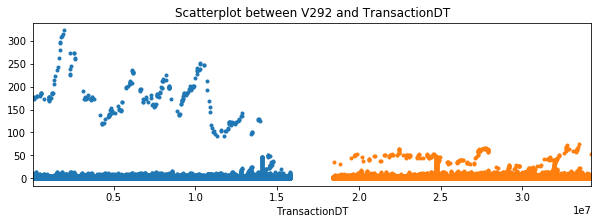

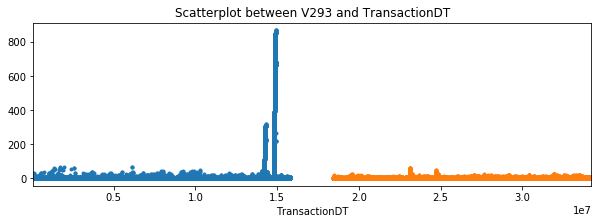

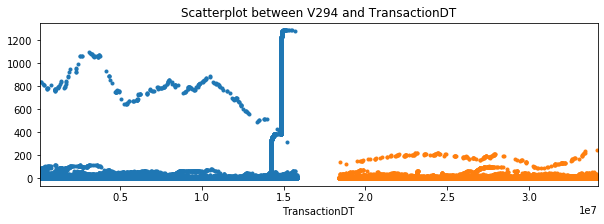

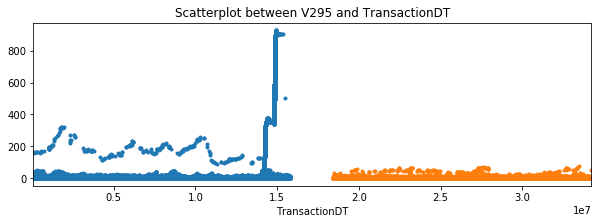

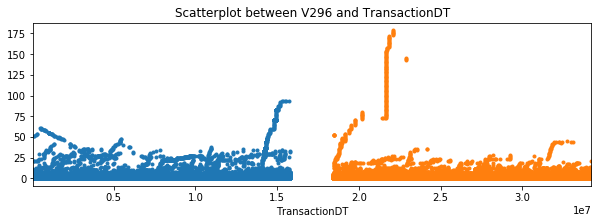

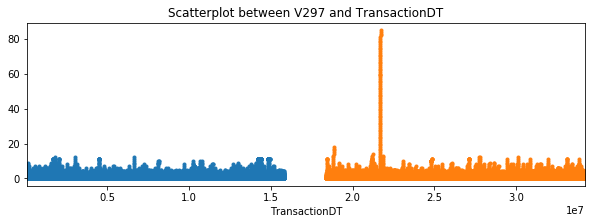

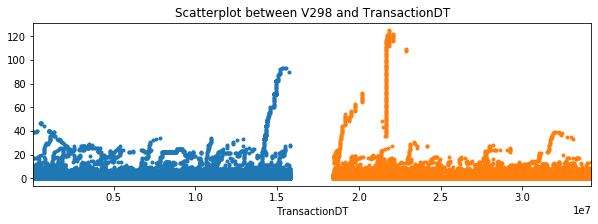

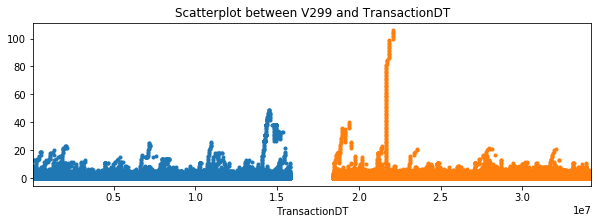

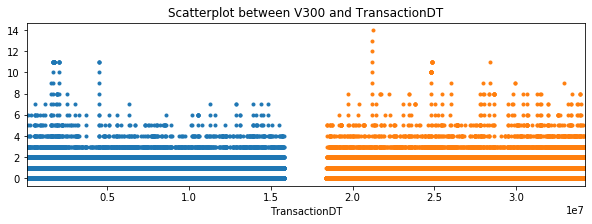

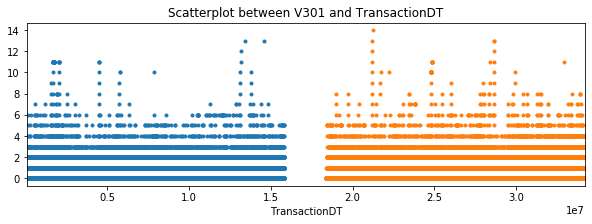

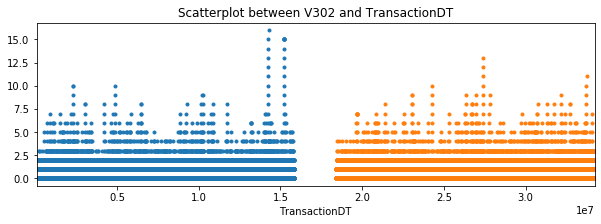

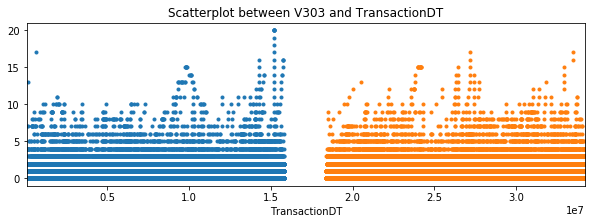

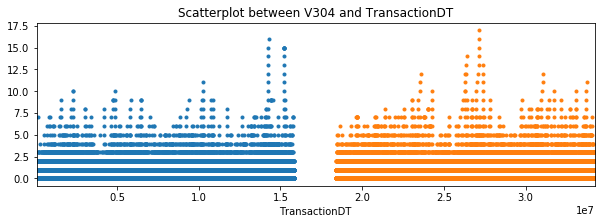

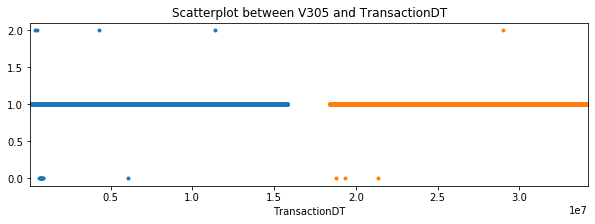

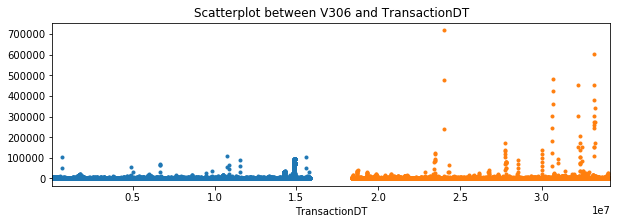

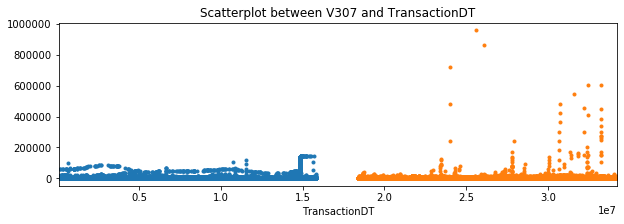

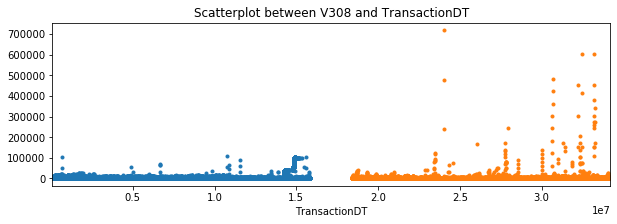

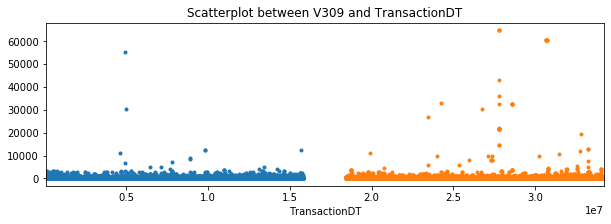

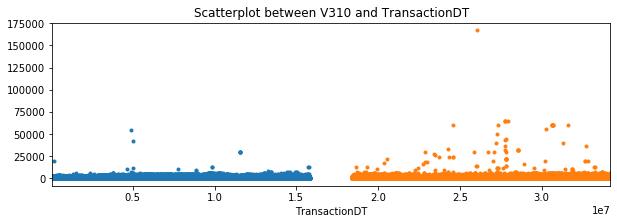

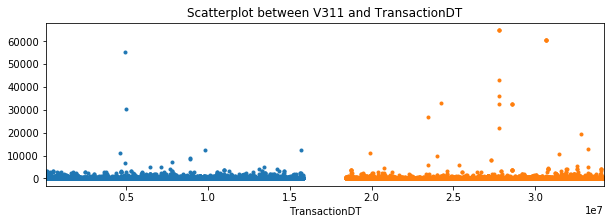

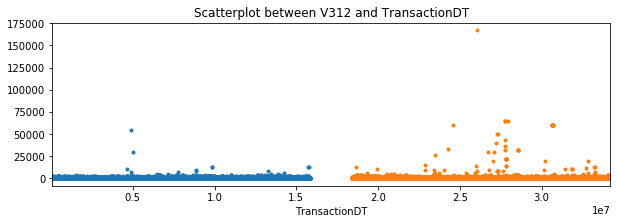

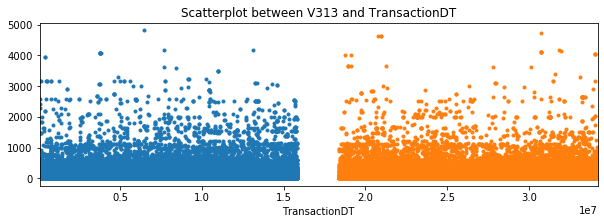

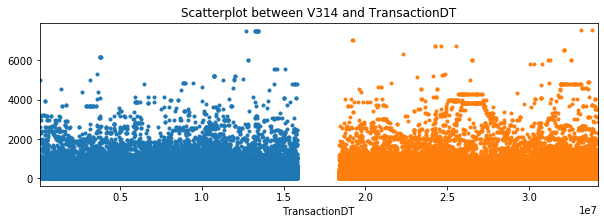

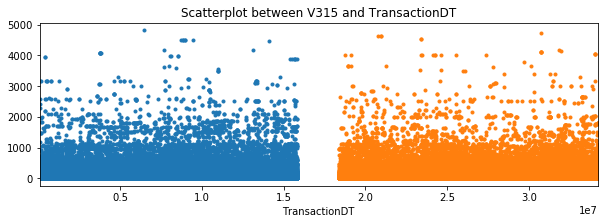

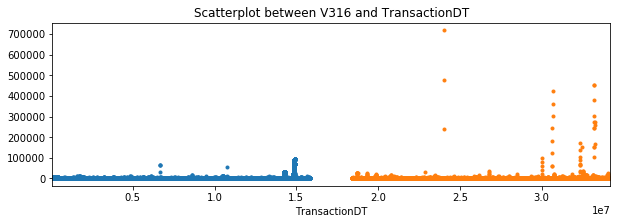

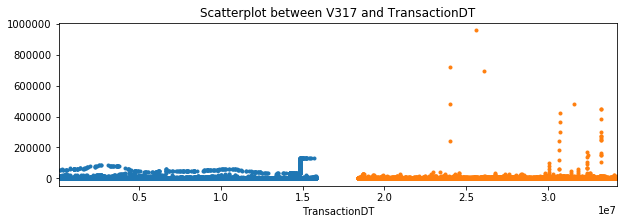

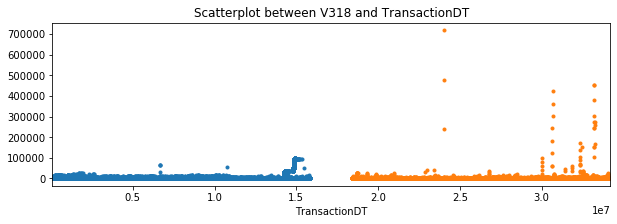

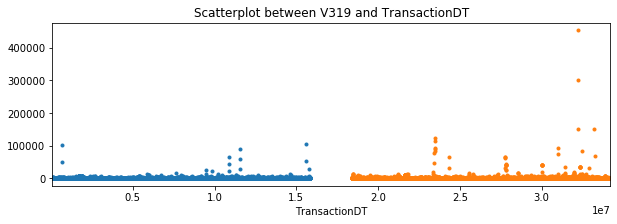

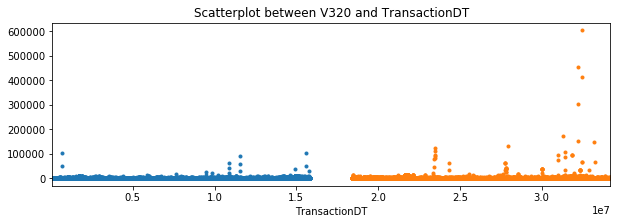

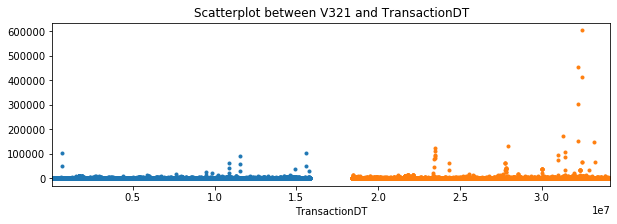

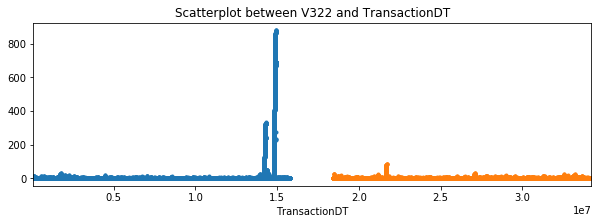

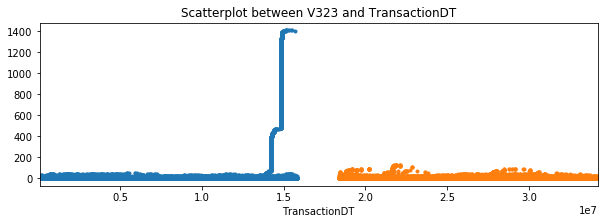

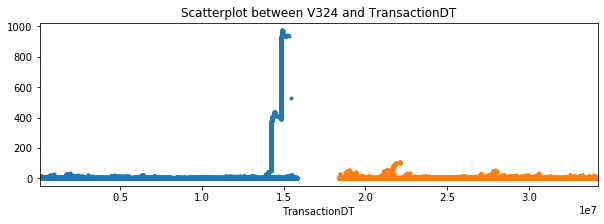

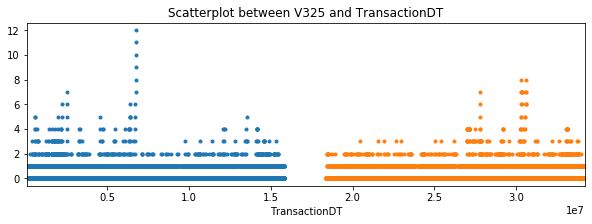

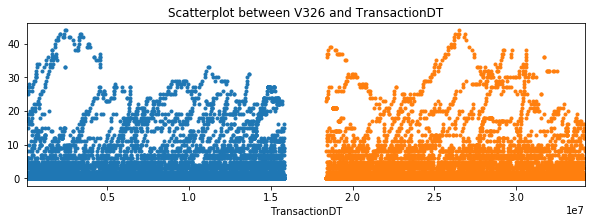

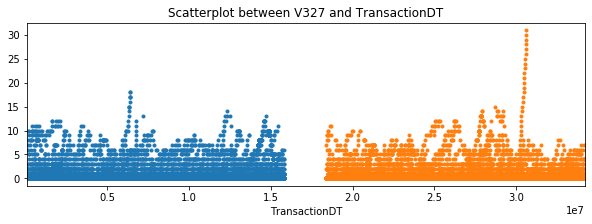

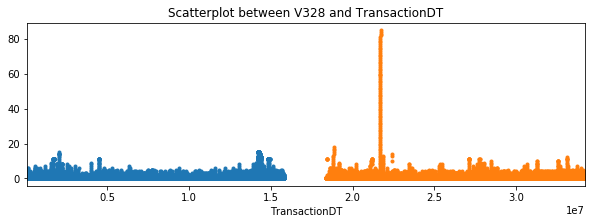

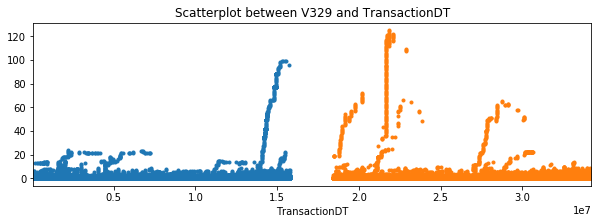

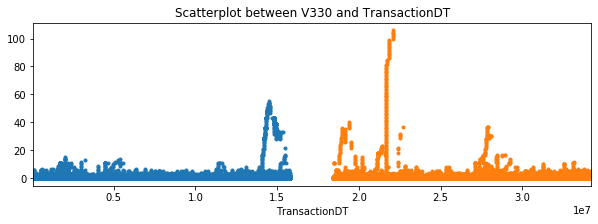

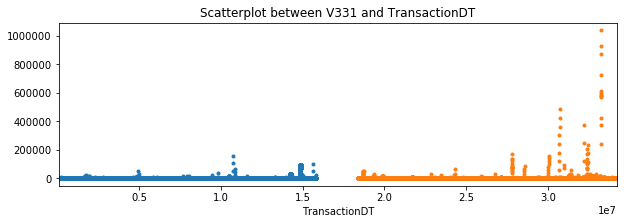

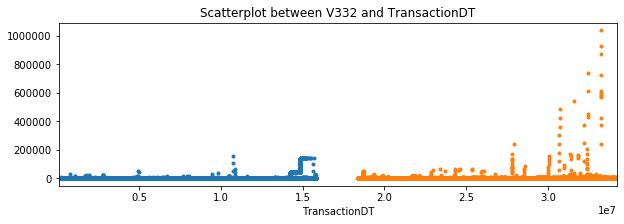

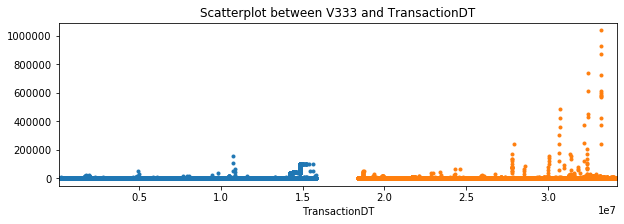

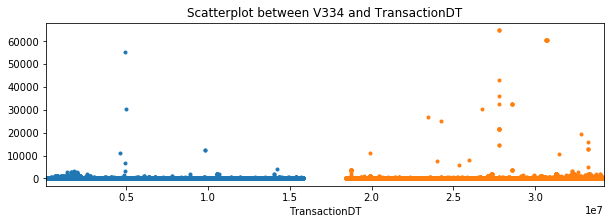

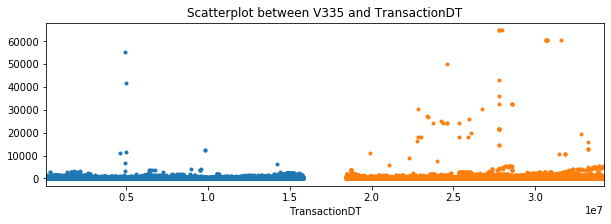

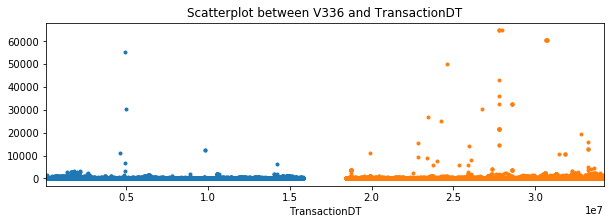

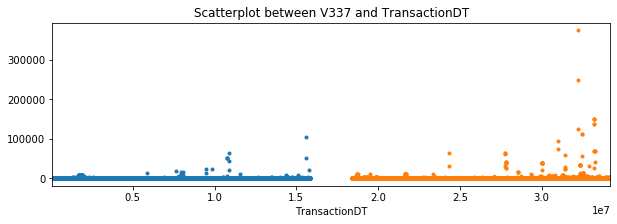

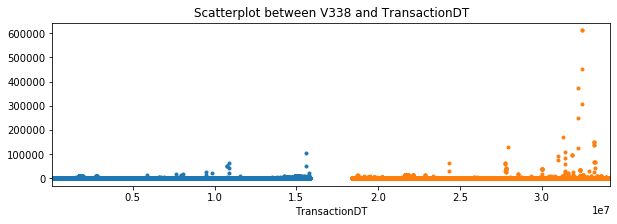

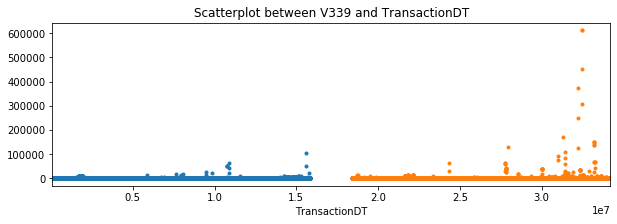

In [372]:
v_features = list(train_transaction.columns[300:])
for i in v_features:
    train_transaction.set_index('TransactionDT')[i].fillna(0) \
    .plot(style='.', title=f'Scatterplot between {i} and TransactionDT',
          figsize=(10, 3))
    test_transaction.set_index('TransactionDT')[i].fillna(0) \
    .plot(style='.', figsize=(10, 3))
    plt.show()

In [ ]:
V95 V145 , V151 V192

## Identity Dataset

* These set of features include things like  network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
* id01 - id11 are numerical features.
* id12-id38 are categorical features

In [385]:
train_df = train_transaction.merge(train_identity, how='left')

In [425]:
test_df = test_transaction.merge(test_identity, how='left')

### Id features

* For numerical id features, there are no clear patterns correlate with TransactionDT. 
* 

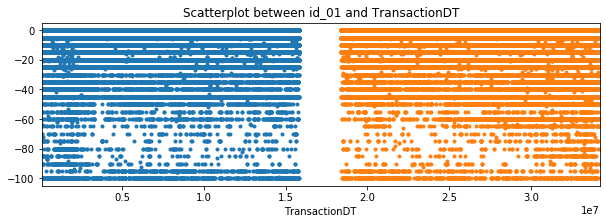

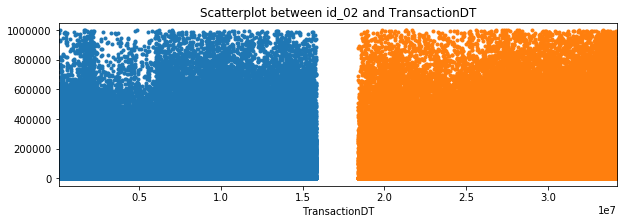

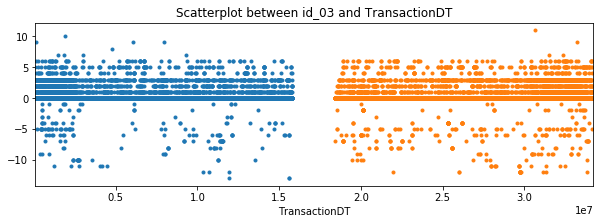

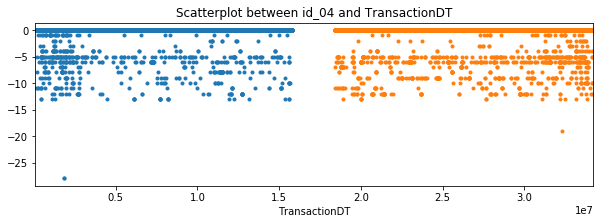

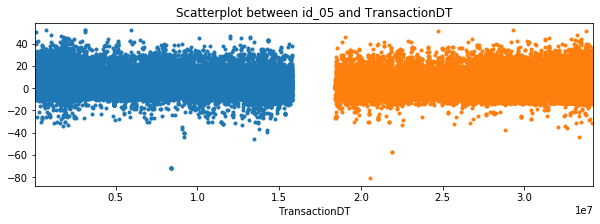

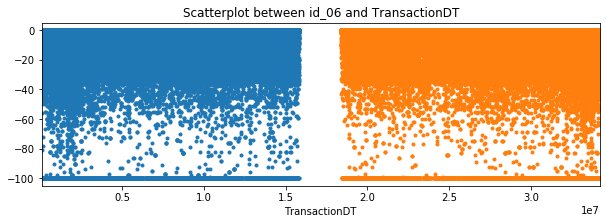

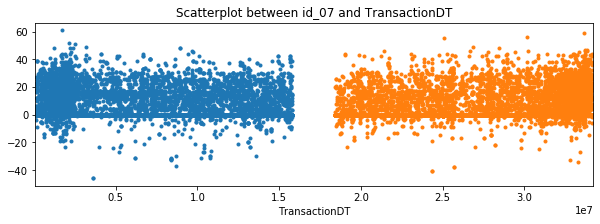

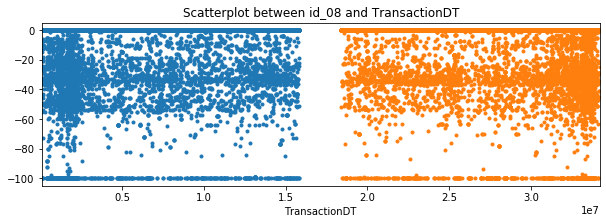

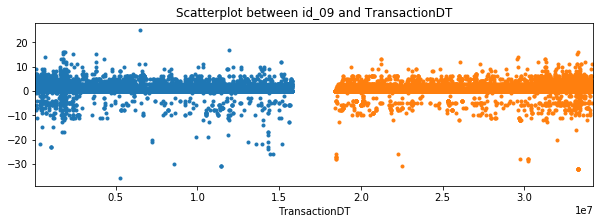

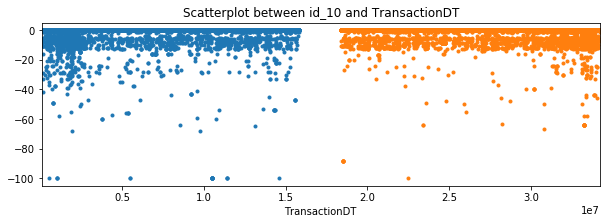

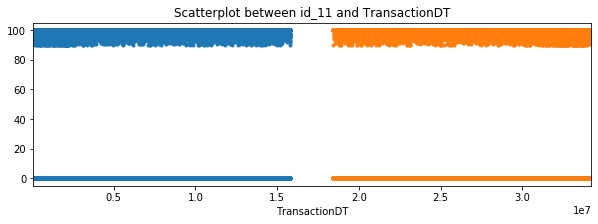

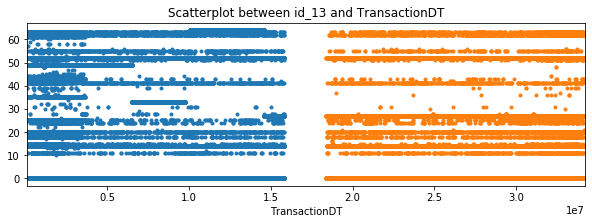

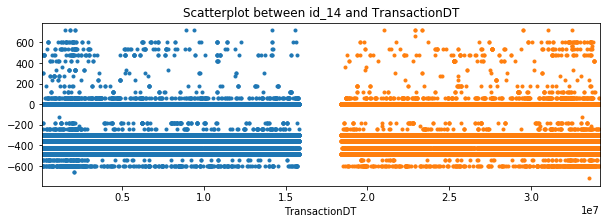

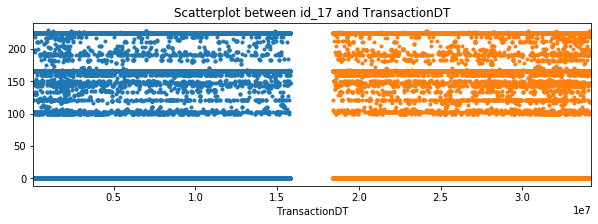

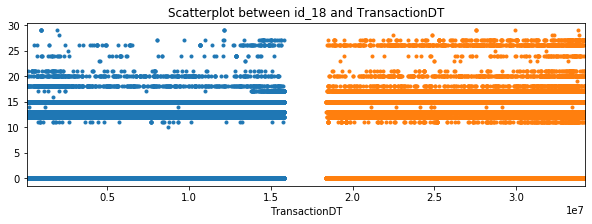

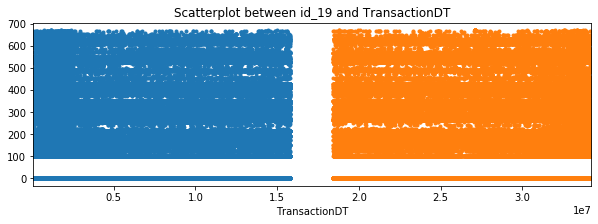

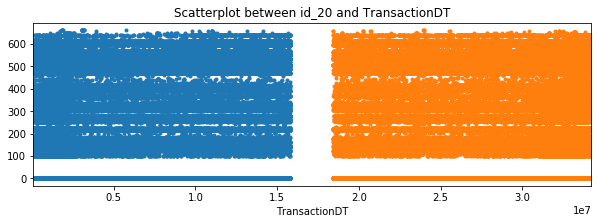

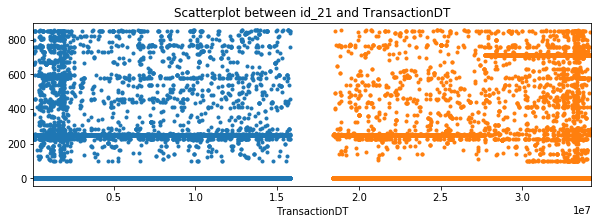

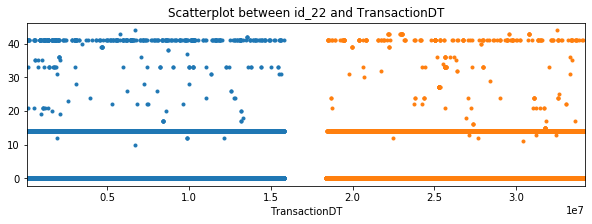

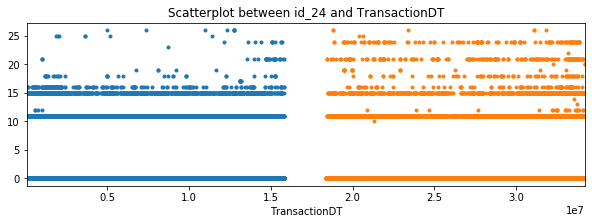

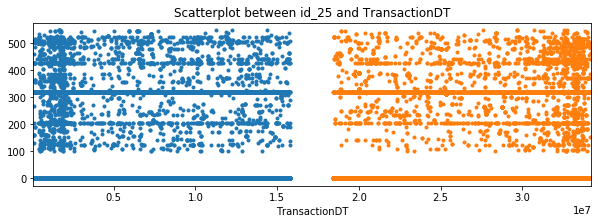

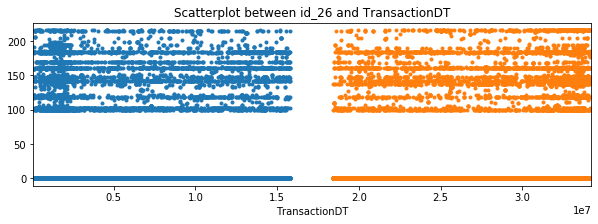

In [430]:
numerical_id = train_df.iloc[:, -40:].columns
for i in numerical_id:
    try:
        train_df.set_index('TransactionDT')[i].fillna(0) \
        .plot(style='.', title=f'Scatterplot between {i} and TransactionDT',
              figsize=(10, 3))
        test_df.set_index('TransactionDT')[i].fillna(0) \
        .plot(style='.', figsize=(10, 3))
        plt.show()
    except TypeError:
        pass


In [432]:
def plot_cat_features(df, col, lim=2000):

    plt.figure(figsize=(14, 10))
    plt.subplot(221)
    g = sns.countplot(x=col, data=df)
    g.set_title(col + ' Distribution', fontsize=14)
    #g.set_xlabel(col + ' Name', fontsize=10)
    g.set_ylabel('Count', fontsize=14)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x() + p.get_width()/2.,
               height,
               f'{height/df.shape[0] * 100:.2f}%',
               ha='center', fontsize=10)

    plt.subplot(222)
    g1 = df.groupby(col)['isFraud'].mean() \
        .sort_index() \
        .plot(kind='bar',
              title='Percentage of Fraud by ' + col,
              color=sns.color_palette())
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x() + p.get_width() / 2.,
                   height,
                   f'{height * 100:.2f}%',
                   ha='center', fontsize=10)
    
    plt.subplot(212)
    g2 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud',
                       data=df[df['TransactionAmt'] <= lim])
    g2.set_title(f"{col} boxplot by TransactionAmt and Fraud")
    g2.set_ylabel("Transaction Values in $")
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

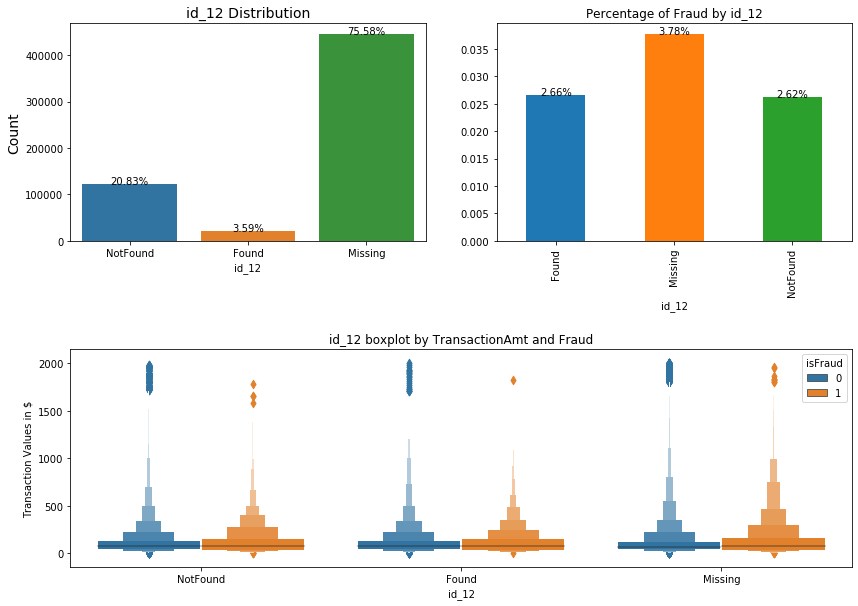

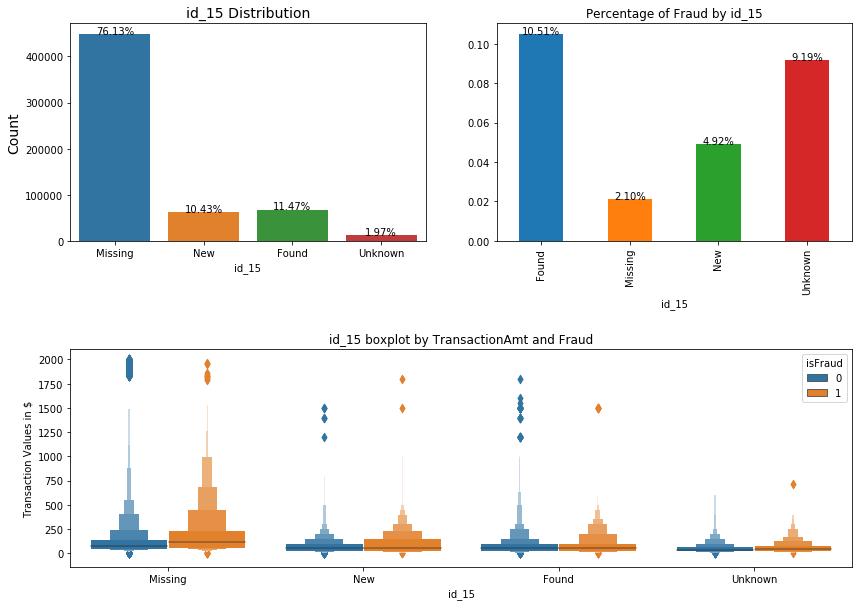

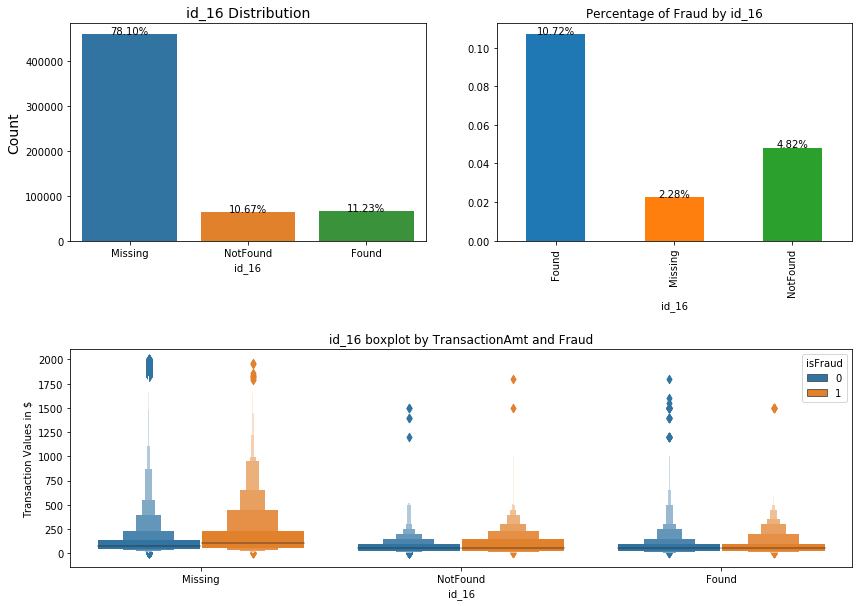

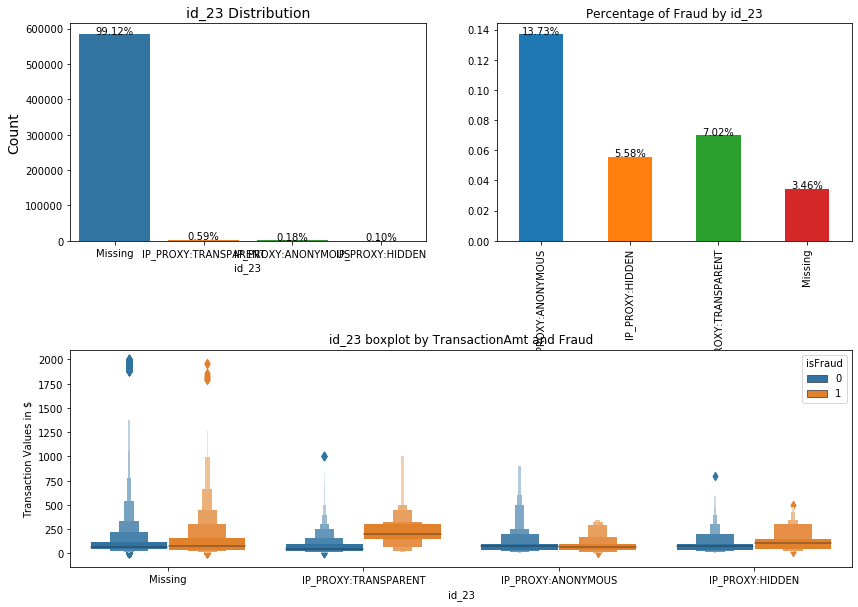

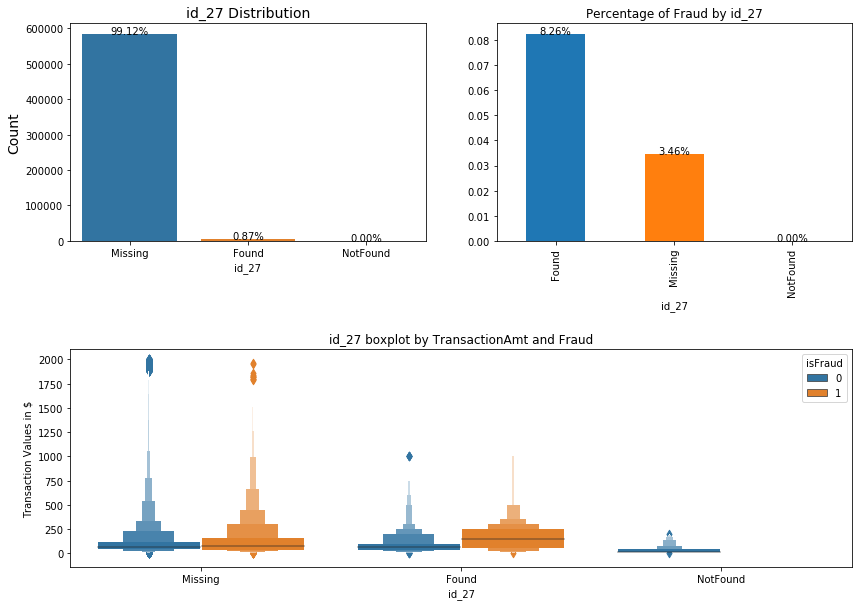

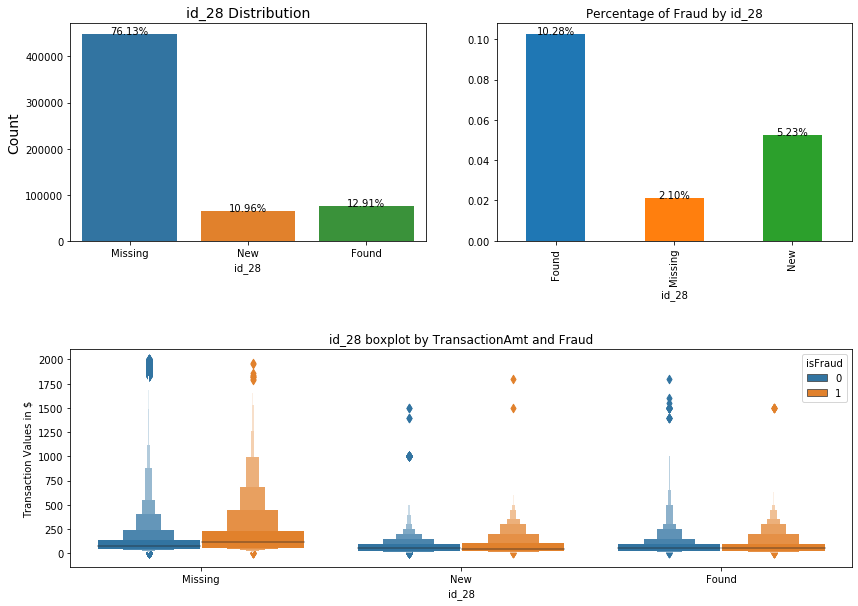

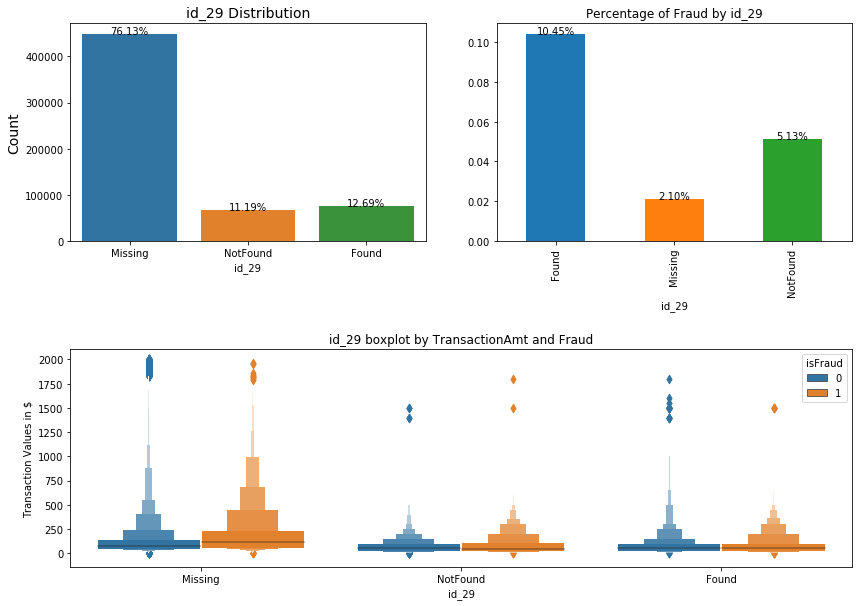

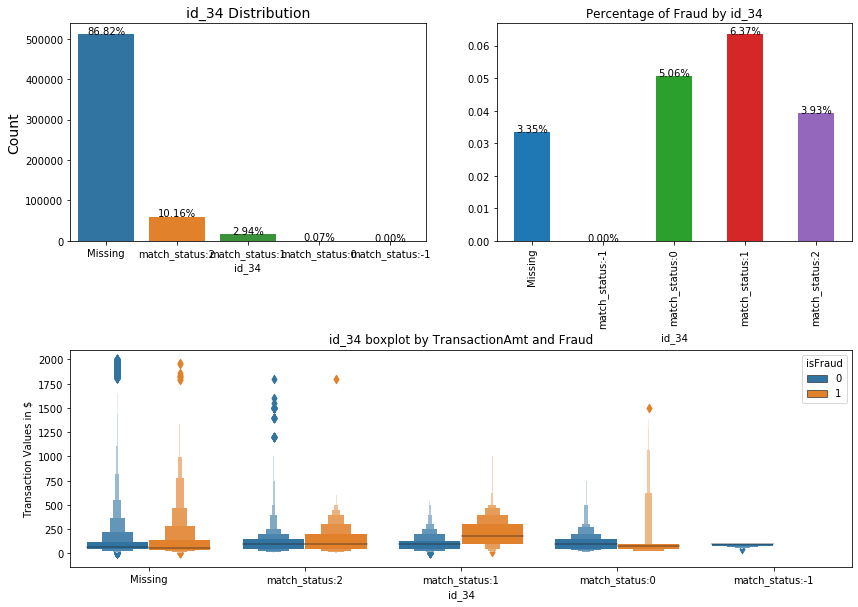

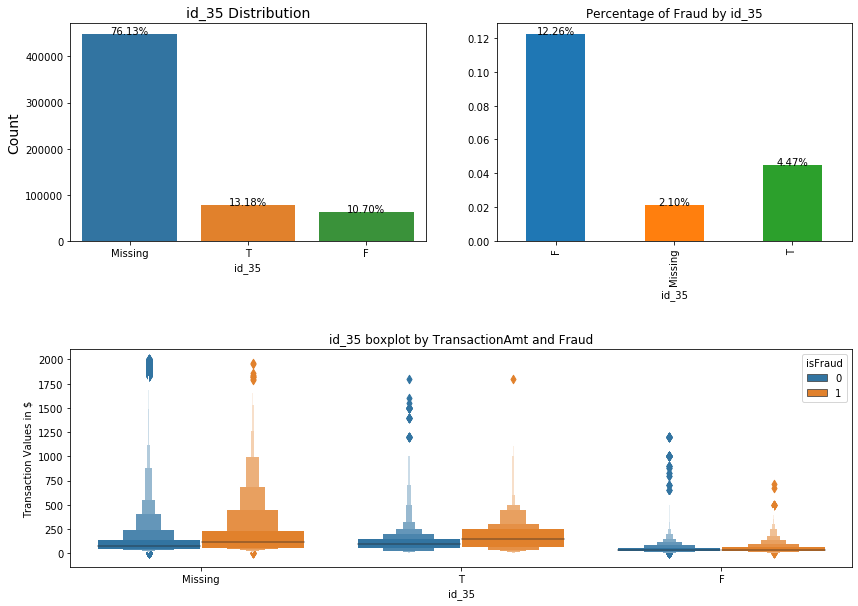

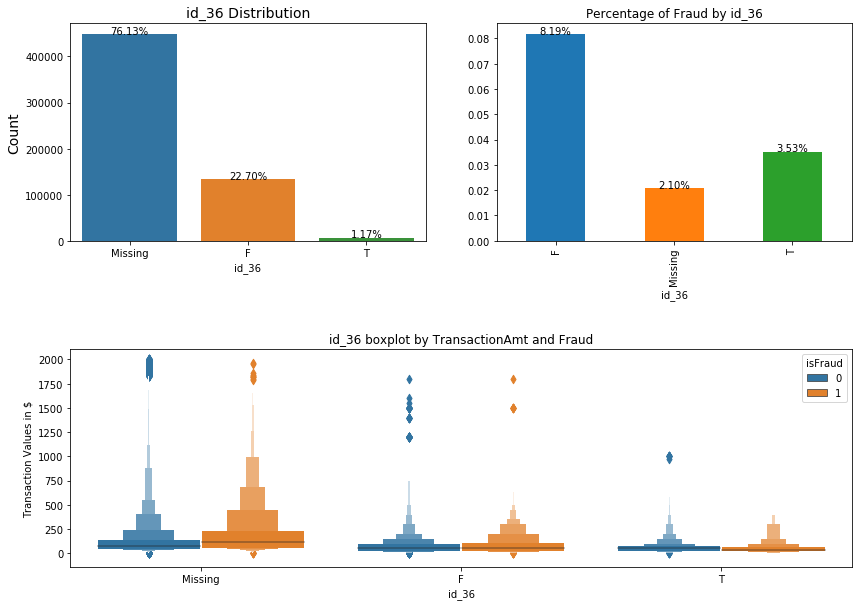

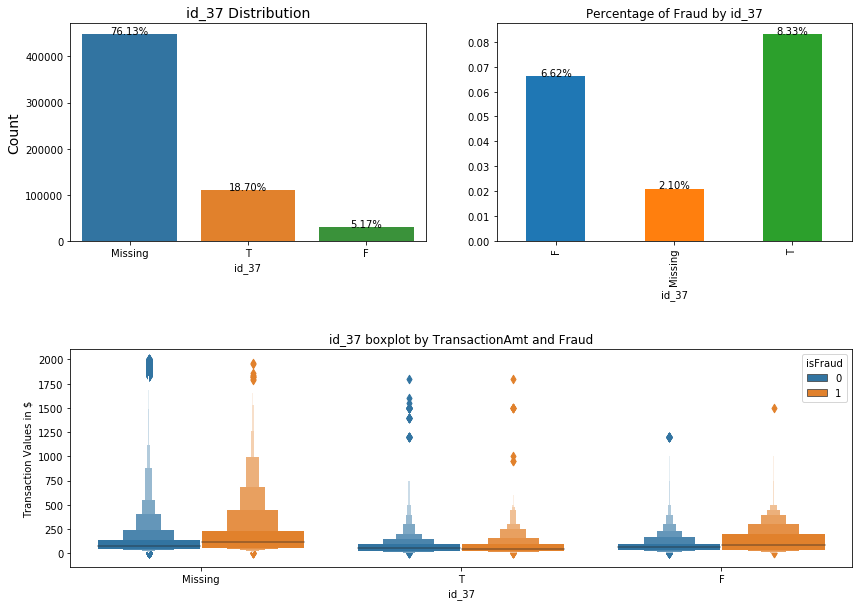

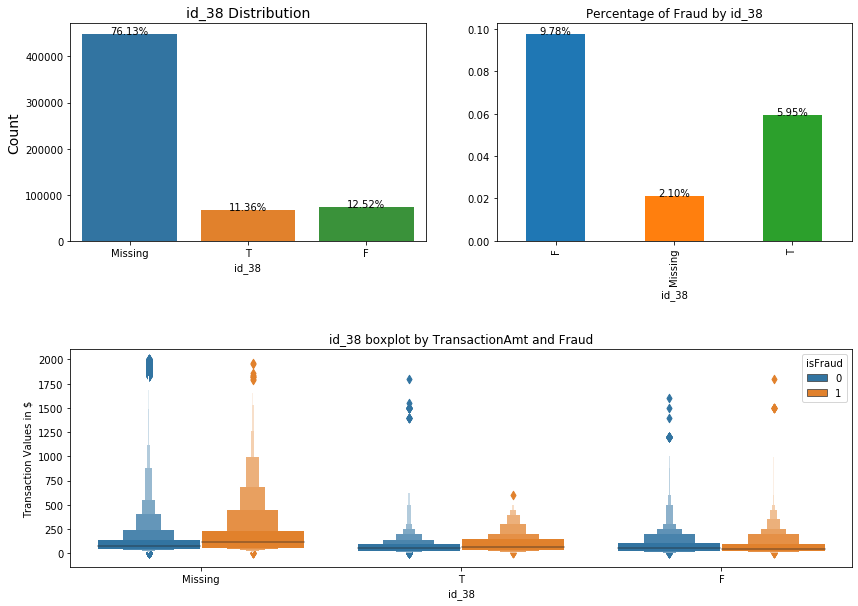

In [428]:
for feature in ['id_12', 'id_15', 'id_16', 'id_23', 'id_27',
                'id_28', 'id_29', 'id_34', 'id_35',
                'id_36', 'id_37', 'id_38']: 
    
    train_df[feature] = train_df[feature].fillna('Missing')
    plot_cat_features(train_df, feature)

### Device Type



In [436]:
resumetable(train_df.iloc[:,-2:])

Dataset Shape: (590540, 2)


Name  dtypes  Missing  Uniques First Value Second Value Third Value
0  DeviceType  object   449730        2         NaN          NaN         NaN
1  DeviceInfo  object   471874     1786         NaN          NaN         NaN

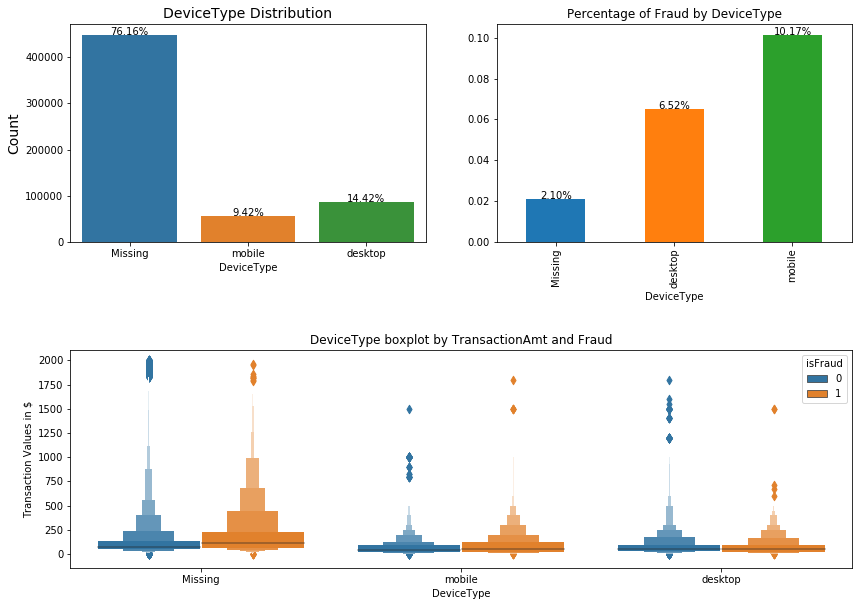

In [437]:
train_df['DeviceType'] = train_df['DeviceType'].fillna('Missing')
plot_cat_features(train_df, 'DeviceType', lim=2000)

### Device Info

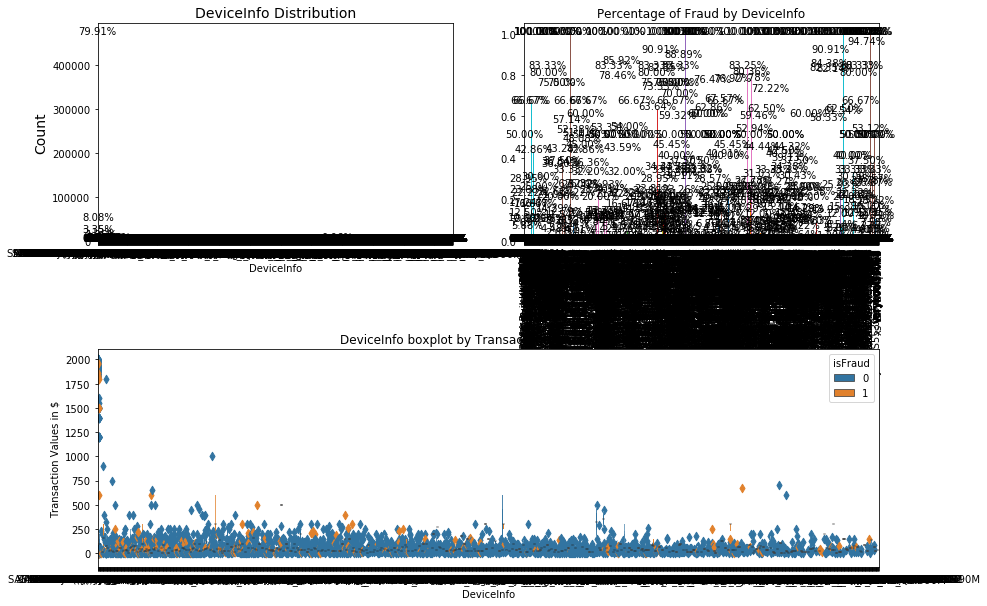

In [439]:
train_df['DeviceInfo'] = train_df['DeviceInfo'].fillna('Missing')
 plt.figure(figsize=(14, 10))
    plt.subplot(221)
    g = sns.countplot(x=col, data=df)
    g.set_title(col + ' Distribution', fontsize=14)
    #g.set_xlabel(col + ' Name', fontsize=10)
    g.set_ylabel('Count', fontsize=14)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x() + p.get_width()/2.,
               height,
               f'{height/df.shape[0] * 100:.2f}%',
               ha='center', fontsize=10)

    plt.subplot(222)
    g1 = df.groupby(col)['isFraud'].mean() \
        .sort_index() \
        .plot(kind='bar',
              title='Percentage of Fraud by ' + col,
              color=sns.color_palette())
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x() + p.get_width() / 2.,
                   height,
                   f'{height * 100:.2f}%',
                   ha='center', fontsize=10)